<header style="width:100%;position:relative">
  <div style="width:80%;float:right;">
    <h1>False Political Claim Detection</h1>
    <h3>Carga y limpieza de los datos</h3>
    <h5>Grupo 2</h5>
  </div>
        <img style="width:15%;" src="./images/logo.jpg" alt="UPM" />
</header>

# Índice

1. [Importar librerias](#1.-Importar-librerias)  
2. [Funciones auxiliares y variables](#2.-Funciones-auxiliares-y-variables)  
3. [Carga del Dataset](#3.-Carga-del-Dataset)  
4. [Limpieza de los datos](#4.-Limpieza-de-los-datos)  
   * 4.1 [Estudio de las columnas](#4.1-Estudio-de-las-columnas)  
   * 4.2 [Tratamiento de los duplicados y de los nulos](#4.2-Tratamiento-de-los-duplicados-y-de-los-nulos)  
   * 4.3 [Tratamiento features](#4.3-Tratamiento-features)  
      * 4.3.1 [Feature Statement](#4.3.1-Feature-Statement)  
      * 4.3.2 [Resto de features](#4.3.2-Resto-de-features)  
5. [Create Test](#5.-Create-Test)  
6. [Exportar CSV](#6.-Exportar-CSV)  
7. [Correlacion](#7.-Correlacion)  
8. [Referencias](#8.-Referencias)


# 1. Importar librerias

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
import json

import matplotlib.pyplot as plt
import seaborn as sns

import spacy

import string
import re

from collections import defaultdict

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.preprocessing import MultiLabelBinarizer

# 2. Funciones auxiliares y variables

- Funciones

In [2]:
def create_collection(df, label, column):    
    collection = []
    
    for x in df[df['label'] == label][column].str.split():
        for i in x:
            collection.append(i)
    return collection


In [3]:
def create_json(outputfile, dict):
    with open(outputfile, 'w', encoding='utf-8') as f:
        json.dump(dict, f, ensure_ascii=False, indent=2)

In [4]:
def save_oov_to_json(oov_dict, output_file="./json-study-statement/oov_words_by_row.json"):
    """
    Guarda el diccionario de palabras fuera del vocabulario (OOV) en un archivo JSON.

    :param oov_dict: Diccionario con las palabras OOV por fila.
    :param output_file: Nombre del archivo JSON de salida.
    """
    try:
        with open('json/json-study-statement/oov_words_by_row.json', "w", encoding="utf-8") as f:
            json.dump(oov_dict, f, ensure_ascii=False, indent=4)
        print(f"Diccionario OOV guardado en: {output_file}")
    except Exception as e:
        print(f"Error al guardar el archivo JSON: {e}")


- variables

In [5]:
# variables generales
nlp = spacy.load('en_core_web_lg')
en_stopwords = nlp.Defaults.stop_words

# 3. Carga del Dataset

In [6]:
url = "data/train.csv" 
data = pd.read_csv(url)
df = data.copy()

url2 = "data/test_nolabel.csv"
df_test = pd.read_csv(url2)

Configuramos Pandas para mostrar todas las columnas de un DataFrame al imprimirlo, y luego mostramos las primeras filas del DataFrame df.

In [7]:
pd.set_option('display.max_columns', None)
df.head()

,id,label,statement,subject,speaker,speaker_job,state_info,party_affiliation
0,81f884c64a7,1,China is in the South China Sea and (building)...,"china,foreign-policy,military",donald-trump,President-Elect,New York,republican
1,30c2723a188,0,With the resources it takes to execute just ov...,health-care,chris-dodd,U.S. senator,Connecticut,democrat
2,6936b216e5d,0,The (Wisconsin) governor has proposed tax give...,"corporations,pundits,taxes,abc-news-week",donna-brazile,Political commentator,"Washington, D.C.",democrat
3,b5cd9195738,1,Says her representation of an ex-boyfriend who...,"candidates-biography,children,ethics,families,...",rebecca-bradley,NaN,NaN,none
4,84f8dac7737,0,At protests in Wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,NaN,Wisconsin,republican


Con *Info* desplegamos la información del dataframe para saber con que datos trabajaremos en cada una de las columnas

In [8]:
df.info

<bound method DataFrame.info of                id  label                                          statement  \
0     81f884c64a7      1  China is in the South China Sea and (building)...   
1     30c2723a188      0  With the resources it takes to execute just ov...   
2     6936b216e5d      0  The (Wisconsin) governor has proposed tax give...   
3     b5cd9195738      1  Says her representation of an ex-boyfriend who...   
4     84f8dac7737      0  At protests in Wisconsin against proposed coll...   
...           ...    ...                                                ...   
8945  44edff2b865      1  If Rhode Island does a hybrid [retirement] pla...   
8946  4a63b5f9c16      1  The new health care law will force seniors int...   
8947  7c57fa8e81c      0  The health insurance plan that (members of Con...   
8948  2375e3cf4b7      1  No one in American history has moved from a Ju...   
8949  5ae9b14e6e5      0  Says the Army is spending $7 million to sponso...   

                   

Gracias a *shape* podemos saber las dimensiones del dataframe, de esta maenra podemos saber la cantidad de filas que tenemos en un incio y la cantidad de columnas con las que trabajaremos

In [9]:
df.shape

(8950, 8)

Visualización del nombre de todas las columnas para plantear la limpieza

In [10]:
df.columns

Index(['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job',
       'state_info', 'party_affiliation'],
      dtype='object')


Visualización del estadisticos de las columnas numericas para plantear la limpieza

# 4. Limpieza de los datos

## 4.1 Estudio de las columnas

Este conjunto de datos está relacionado con la detección de afirmaciones políticas falsas y contiene declaraciones (o afirmaciones) etiquetadas junto con metadatos sobre el orador, el tema y otra información contextual. A continuación, se presenta un desglose detallado de la estructura y las características clave del conjunto de datos:

| **Field Name**      | **Data Type** | **Description**                                                                 |
|----------------------|---------------|---------------------------------------------------------------------------------|
| **id**              | Text          | Identificador Único                                                              |
| **label**           | Integer       | Puntuación de veracidad. Clasificación binaria: 1 = verdadero, 0 = falso                |
| **statement**       | Text          | Texto de declaración                                                              |
| **subject**         | Text          | Tema de la declaración                                                             |
| **speaker**         | Text          | Persona que hace al declaración                                                        |
| **speaker_job**     | Text          | Profesión de la persona                                                      |
| **state_info**      | Text          | Contexto geográfico                                                             |
| **party_affiliation** | Text        | Partido politico del *speaker*                                                 |


Visualización de los tipos de cada columna

In [11]:
df.dtypes

id                   object
label                 int64
statement            object
subject              object
speaker              object
speaker_job          object
state_info           object
party_affiliation    object
dtype: object

Visualizacón de valores distintos que tienen cada columna

In [12]:
# Obtener el número de valores distintos de cada columna
valores_distintos = {columna: df[columna].nunique() for columna in df.columns}

# Mostrar el número de valores distintos de cada columna
for columna, num_valores in valores_distintos.items():
    print(f"Columna: {columna}, Valores distintos: {num_valores}")

Columna: id, Valores distintos: 8950
Columna: label, Valores distintos: 2
Columna: statement, Valores distintos: 8939
Columna: subject, Valores distintos: 3409
Columna: speaker, Valores distintos: 2634
Columna: speaker_job, Valores distintos: 1090
Columna: state_info, Valores distintos: 78
Columna: party_affiliation, Valores distintos: 24


Creación del Dataset sobre el que trabajaremos

In [13]:
# dfc = df.drop(columns='id')
dfc = df
dfc.head()

,id,label,statement,subject,speaker,speaker_job,state_info,party_affiliation
0,81f884c64a7,1,China is in the South China Sea and (building)...,"china,foreign-policy,military",donald-trump,President-Elect,New York,republican
1,30c2723a188,0,With the resources it takes to execute just ov...,health-care,chris-dodd,U.S. senator,Connecticut,democrat
2,6936b216e5d,0,The (Wisconsin) governor has proposed tax give...,"corporations,pundits,taxes,abc-news-week",donna-brazile,Political commentator,"Washington, D.C.",democrat
3,b5cd9195738,1,Says her representation of an ex-boyfriend who...,"candidates-biography,children,ethics,families,...",rebecca-bradley,NaN,NaN,none
4,84f8dac7737,0,At protests in Wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,NaN,Wisconsin,republican


- Obeservar si el dataset está balanceado

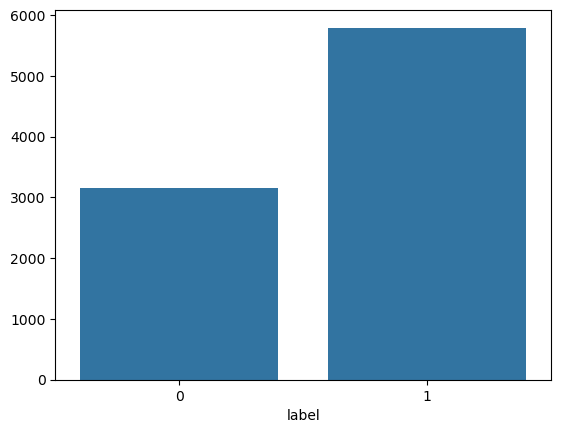

In [14]:
x = dfc['label'].value_counts()
sns.barplot(x=x.index, y=x.values)
plt.show()

Está bastante desequilibrado; hay muchos más textos que no son bulos que son bulos.

## 4.2 Tratamiento de los duplicados y de los nulos

Comprobación de duplicados

In [15]:
print(dfc.duplicated().any())

False


No hay duplicados

Comporbación de si existen nulos y en que columnas se encuentran

In [16]:
dfc.isnull().sum() 

id                      0
label                   0
statement               0
subject                 0
speaker                 0
speaker_job          2482
state_info           1930
party_affiliation       0
dtype: int64

In [17]:
# Calcular nulos cuando label es 1
nulls_label_1 = dfc[dfc['label'] == 1].isnull().sum()

# Calcular nulos cuando label es 0
nulls_label_0 = dfc[dfc['label'] == 0].isnull().sum()

# Mostrar resultados
print("Nulos cuando label es 1:")
print(nulls_label_1)

print("\nNulos cuando label es 0:")
print(nulls_label_0)

Nulos cuando label es 1:
id                      0
label                   0
statement               0
subject                 0
speaker                 0
speaker_job          1731
state_info           1385
party_affiliation       0
dtype: int64

Nulos cuando label es 0:
id                     0
label                  0
statement              0
subject                0
speaker                0
speaker_job          751
state_info           545
party_affiliation      0
dtype: int64


Al ser demasiados nulos intentaremos sacar la información de otras columnas

## 4.3 Tratamiento features

### 4.3.1 Feature Statement

#### Tratar orignal statement

Exportan en json todas las *statements* para que sea más fácil visualizarlas y ver como podemos tratarlas

In [18]:
statement_counts_dict = dfc['statement'].to_dict()

create_json('json/json-study-statement/statements.json',statement_counts_dict)

Corrección de Ill a i'll

In [19]:
dfc['statement'] = dfc['statement'].str.replace("Ill", "i'll")


Visualicación de las palabrás *stopwords* más comunes cuando no son bulos

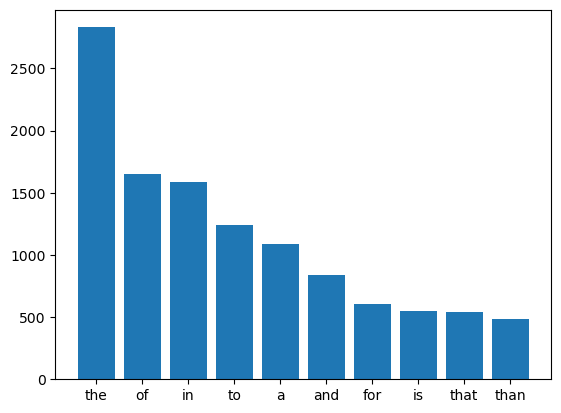

In [20]:
#Common stopwords in no fake claims, label 0
collection=create_collection(dfc,0,'statement')

dic=defaultdict(int)
for word in collection: 
    if word in en_stopwords:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y)
plt.show()

Visualicación de las palabrás *stopwords* más comunes cuando es un bulo

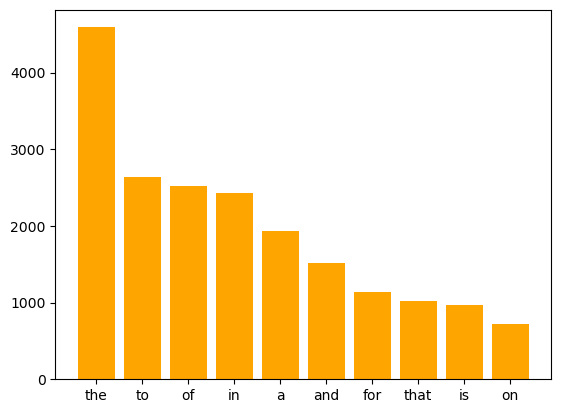

In [21]:
collection=collection=create_collection(dfc,1,'statement')


dic=defaultdict(int)
for word in collection:
    if word in en_stopwords:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y,color='orange')
plt.show()

Como podemos comprobar que en tanto en fake claims como en no fake claims comparten palabras *stopwords* muy similares, por lo que en raw las eliminaremos

Diccionario de remapeo para estructurarlo de manera adecuada

In [22]:
replacements = {
    r'\bim\b': "i'm",
    r'\byoure\b': "you're",
    r'\bhes\b': "he's",
    r'\bshes\b': "she's",
    r'\bits\b': "it's",
    r'\btheyre\b': "they're",
    r'\byoud\b': "you'd",
    r'\bhed\b': "he'd",
    r'\bshed\b': "she'd",
    r'\bwed\b': "we'd",
    r'\btheyd\b': "they'd",
    r'\byoull\b': "you'll",
    r'\bhell\b': "he'll",
    r'\bshell\b': "she'll",
    r'\bitll\b': "it'll",
    r'\bwell\b': "we'll",
    r'\btheyll\b': "they'll",
    # hasnt
    r'\bhavent\b': "haven't",
    r'\bhasnt\b': "hasn't",
    r'\bdidnt\b': "didn't",
    r'\bwont\b': "won't",
    r'\bwouldnt\b': "wouldn't",
    r'\bcant\b': "can't",
    r'\bcouldnt\b': "couldn't",
    r'\bisnt\b': "isn't",
    r'\barent\b': "aren't",
    r'\bshouldnt\b': "shouldn't",
    r'\bwasnt\b': "wasn't",
    r'\bwerent\b': "weren't",
    r'\bdont\b': "don't",
    r'\bdoesnt\b': "doesn't",
    r'\bmightnt\b': "mightn't",
    r'\bmustnt\b': "mustn't",
    r'\bneednt\b': "needn't",
    r'\bwhyd\b': "why'd",
    r'\bwholl\b': "who'll",
    r'\bwhod\b': "who'd",
    r'\bwhos\b': "who's",
    r'\bwhats\b': "what's",
    r'\bwhens\b': "when's",
    r'\bwhys\b': "why's",
    r'\bwhereas\b': "where's",
    r'\bwhereve\b': "where've",
}

# Función para aplicar los reemplazos
def replace_words(text):
    for pattern, replacement in replacements.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    return text

Remapeo de las palabras en función del diccionario anterior.

In [23]:
# Aplicar la función a la columna 'statement'
dfc['statement'] = dfc['statement'].apply(replace_words)

# Verificar el resultado en las primeras filas
print(dfc['statement'].head())

0    China is in the South China Sea and (building)...
1    With the resources it takes to execute just ov...
2    The (Wisconsin) governor has proposed tax give...
3    Says her representation of an ex-boyfriend who...
4    At protests in Wisconsin against proposed coll...
Name: statement, dtype: object


Pasos realizados por la función ***preprocess***

1. <u>Limpieza inicial del texto</u>:

Elimina espacios en blanco adicionales y recorta los espacios al inicio y al final del texto usando re.sub(r'\s+', ' ', text).strip().

2. <u>Reemplazo de palabras específicas</u>:

Aplica la función replace_words para realizar reemplazos basados en un diccionario predefinido de patrones y sustituciones (como convertir "Ill" a "I'll").

3. <u>Tokenización y análisis con SpaCy</u>:

Convierte el texto en un objeto doc utilizando el modelo de lenguaje de SpaCy (nlp).

4. <u>Eliminación de URLs</u>:

Si un token es identificado como una URL (token.like_url), se elimina y se incrementa el contador url_changes.

5. <u>Eliminación de números</u>:

Si un token contiene números (token.like_num o caracteres numéricos), se elimina y se incrementa el contador digit_changes.

6. <u>Eliminación de puntuación</u>:

Si un token es puntuación (token.is_punct o contiene caracteres de puntuación), se elimina y se incrementa el contador punct_changes.

7. <u>Normalización de negaciones</u>:

Detecta palabras de negación (como "not", "never") o sufijos de negación (como "n't") y las normaliza a "not". Incrementa el contador not_changes.

8. <u>Eliminación de auxiliares</u>:

Si un token es un verbo auxiliar (token.pos_ == "AUX") y cumple ciertas condiciones, se elimina.

9. <u>Eliminación de stopwords</u>:

Elimina stopwords (palabras comunes como "the", "and") excepto si son verbos, sustantivos, pronombres propios o negaciones. Incrementa el contador stopword_changes.

10. <u>Construcción del texto procesado</u>:

Los tokens restantes se agregan a una lista y se unen en una cadena de texto final.

11. <u>Identificación de palabras fuera del vocabulario (OOV)</u>:

Si un token no está en el vocabulario del modelo (token.is_oov), se agrega a un diccionario de palabras fuera del vocabulario (oov_words_by_row).

12. <u>Retorno del texto procesado</u>:

Devuelve el texto procesado como una cadena.

In [24]:
# Diccionario de palabras fuera del vocabulario (OOV)
oov_words_by_row = {}

# Contadores globales
digit_changes = 0
punct_changes = 0
url_changes = 0
stopword_changes = 0
not_changes = 0

# Palabras de negación completasstring.punctuation
negation_words = {
    "not", "never", "no", "nor", "cannot", "nobody", "none",
    "nothing", "nowhere", "neither", "can't", "dont", "won't", 
    "don't", "aren't", "isn't", "wasn't", "couldn't", 
    "shouldn't", "wouldn't", "didn't", "hasn't", "haven't", "hadn't"
}

# También detectaremos contracciones con n't
negation_suffixes = ("n't", "'t")


def preprocess(text, row_number=None):
    global digit_changes, punct_changes, url_changes, stopword_changes, not_changes

    text = re.sub(r'\s+', ' ', text).strip()
    text = replace_words(text)  # asumes que tienes esta función

    doc = nlp(text)
    tokens = []
    oov_tokens = []

    for token in doc:
        # Eliminar URLs
        if token.like_url:
            url_changes += 1
            continue

        # Eliminar números
        if token.like_num or any(char.isdigit() for char in token.text):
            digit_changes += 1
            continue

        # Eliminar puntuación
        if token.is_punct or token.is_space or any(char in string.punctuation for char in token.text):
            punct_changes += 1
            continue

        lower_token = token.text.lower()

        # Detectar y normalizar negaciones
        if lower_token in negation_words or lower_token.endswith(negation_suffixes):
            tokens.append("not")
            not_changes += 1
            continue

        # Eliminar auxiliares si realmente lo son (usados como "aux")
        if token.pos_ == "AUX" and token.dep_ == "aux":
            continue

        # Eliminar stopwords solo si no son VERB, NOUN, PROPN o negaciones
        if token.is_stop and token.pos_ not in {"VERB", "NOUN", "PROPN", "AUX", "PRON"}:
            stopword_changes += 1
            continue


        # # Lematizar verbos y auxiliares no auxiliares
        # if token.pos_ in {"VERB", "AUX"}:
        #     tokens.append(token.lemma_)
        # else:
        #     tokens.append(token.text)

        tokens.append(token.text)
        if token.is_oov:
            oov_tokens.append(token.text)

    if row_number is not None and oov_tokens:
        oov_words_by_row[row_number] = oov_tokens

    return ' '.join(tokens)

# ------------------- Sección de pruebas -------------------
if __name__ == "__main__":
    ejemplos = [
        "China is in the South China Sea and (building)a military fortress the likes of which perhaps the world has not seen.",
        # "I had not check library book photo ID",
        # "The new Arizona immigration law \"says that any police officer can stop anyone who appears to them to be reasonably suspicious of being an undocumented person.\"",
        # "Hospitals, doctors, MRIs, surgeries and so forth are more extensively used and far more expensive in this country than they are in many other countries.''\thealth-care\tmitt-romney\tFormer governor\tMassachusetts\trepublican\t34\t32\t58\t33\t19\ta Fox News Sunday interview\n9874.json\tbarely-true\tObamacare cuts seniors Medicare.\thealth-care,medicare\ted-gillespie\tRepublican strategist\tWashington, D.C.\trepublican\t2\t3\t2\t2\t1\ta campaign email.\n3072.json\tmostly-true\tThe refusal of many federal employees to fly coach costs taxpayers $146 million annually.\tgovernment-efficiency,transparency\tnewsmax\tMagazine and website\tFlorida\tnone\t0\t0\t0\t1\t0\tan e-mail solicitation\n2436.json\tmostly-true\tFlorida spends more than $300 million a year just on children repeating pre-K through 3rd grade.\teducation\talex-sink\t\tFlorida\tdemocrat\t1\t2\t2\t4\t0\tfigures cites on campaign website\n9721.json\ttrue\tMilwaukee County Sheriff David A. Clarke Jr. advised citizens to point that barrel center mass and pull the trigger because 911 is not our best option.\tcrime,criminal-justice,guns,legal-issues\tgreater-wisconsin-political-fund\t\tWisconsin\tnone\t3\t3\t3\t1\t1\ta campaign TV ad\n3627.json\tfalse\tAlmost 37 percent of the total income from Planned Parenthood is from abortions.\tabortion\tronald-renuart\tState Representative\tFlorida\trepublican\t0\t1\t0\t0\t0\tcomments during a committee hearing\n11900.json\thalf-true\tThe United States has the highest rate of childhood poverty of almost any major country on Earth.\tchildren,poverty\tbernie-s\tU.S. Senator\tVermont\tindependent\t18\t12\t22\t41\t0\tcomments during the PBS Democratic debate\n4611.json\ttrue\tUnder Governor Almond the RI DMV had a program that allowed undocumented [people to] use their Personal Tax Identification Number . . . to apply [for] and receive a RI drivers license.\tcivil-rights,homeland-security,immigration,public-safety,transportation,workers\tdavid-quiroa\tprresident, Guatemalan-American Alliance of Rhode Island\tRhode Island\tnewsmaker\t0\t0\t0\t0\t0\ta news release\n3168.json\tpants-fire\tIllegal aliens cost the state of Rhode Island $400 million a year.\tcensus,crime,education,health-care,immigration,state-budget,taxes\tterry-gorman\tPresident, Rhode Islanders for Immigration Law Enforcement\tRhode Island\tnewsmaker\t1\t0\t0\t0\t1\ta radio interview\n6832.json\tpants-fire\tSays Eric Cantor voted to assure Congress would be paid if the government shut down and against guaranteeing troops would be paid.\tcongressional-rules,federal-budget,military\twayne-powell\tlawyer\tVirginia\tdemocrat\t1\t1\t0\t0\t1\ta debate.\n5893.json\tmostly-true\tIf Congress froze the current spending level and then cut it by 2 percent annually, we could balance the budget in five years.\tdeficit,federal-budget\tjamie-radtke\t\tVirginia\trepublican\t1\t1\t1\t2\t0\ta statement\n3304.json\ttrue\tEvery (Wisconsin) legislator that votes for this bill will have to give up the same amount of pay as other state employees.\tlabor,state-budget\tjeff-fitzgerald\tIncoming speaker of state Assembly\tWisconsin\trepublican\t2\t0\t1\t2\t2\tan interview on the Fox News Channel\n1638.json\thalf-true\tMarco Rubio controlled funds that out of the $600,000 that were raised, only $4,000 went to candidates to try to improve their chances to be elected to office.\"",
    ]

    for s in ejemplos:
        print(f"Original: {s}")
        resultado = preprocess(s,1)
        print(f"Procesado: {resultado}\n")

    print(f"URLs eliminadas: {url_changes}")
    print(f"Puntuaciónes eliminadas: {punct_changes}")
    print(f"Stopwords eliminadas: {stopword_changes}")
    print(f"Dígitos eliminados: {digit_changes}")


Original: China is in the South China Sea and (building)a military fortress the likes of which perhaps the world has not seen.
Procesado: China is South China Sea military fortress likes which world not seen

URLs eliminadas: 0
Puntuaciónes eliminadas: 3
Stopwords eliminadas: 7
Dígitos eliminados: 0


Aplicar la función de procesamiento a la columna *'statement'* del dataset, guardandolo en *'statement-raw'* con toda las frases en minúscula

In [25]:
dfc['statement-raw'] = dfc.apply(lambda row: preprocess(row['statement'], row.name), axis=1)
dfc['statement-raw'] = dfc['statement-raw'].str.lower()
save_oov_to_json(oov_words_by_row)



# Mostrar los contadores
print(f"URLs eliminadas: {url_changes}")
print(f"Puntuaciones eliminadas: {punct_changes}")
print(f"Stopwords eliminadas: {stopword_changes}")
print(f"Dígitos eliminados: {digit_changes}")

Diccionario OOV guardado en: ./json-study-statement/oov_words_by_row.json
URLs eliminadas: 30
Puntuaciones eliminadas: 23275
Stopwords eliminadas: 47655
Dígitos eliminados: 7956


Visualicación de las palabrás más comunes cuando no es un bulo trás el procesado

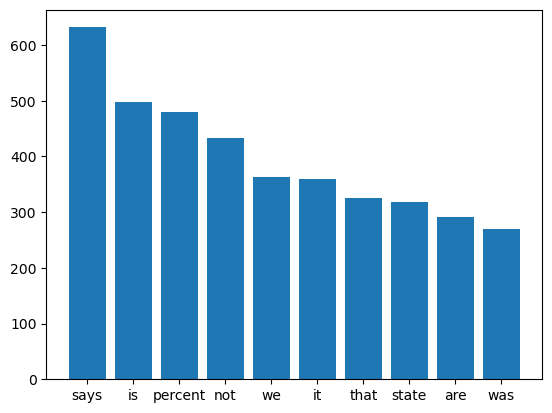

In [26]:
collection=create_collection(dfc,0,'statement-raw')


dic=defaultdict(int)
for word in collection: 
    dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y)
plt.show()

Visualicación de las palabrás más comunes cuando es un bulo trás el procesado

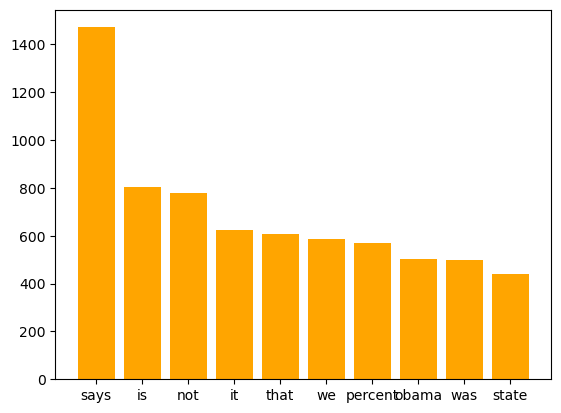

In [27]:
collection=create_collection(dfc,1,'statement-raw')


dic=defaultdict(int)
for word in collection: 
    dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y, color='orange')
plt.show()

Creación de json para visualizarlo de manera más sencilla

In [28]:
statement_counts_dict = dfc['statement-raw'].to_dict()
create_json('json/json-study-statement/statements_raw.json',statement_counts_dict)

#### Lematize

Pasos realizados por la función ***lemmatize_verbs***

1. <u>Tokenización del texto</u>:

Utiliza el modelo de lenguaje SpaCy (nlp) para dividir el texto en tokens y analizar su estructura gramatical.

2. <u>Inicialización de la lista de salida</u>:

Crea una lista vacía lemmatized_text para almacenar los tokens procesados.

3. <u>Procesamiento de cada token</u>:

    - Ignorar auxiliares usados como auxiliares: 
        Si el token es un verbo auxiliar (token.pos_ == "AUX") y su dependencia gramatical es auxiliar (token.dep_ == "aux"), se omite.

    - Lematización de verbos y auxiliares no auxiliares:  
        Si el token es un verbo (VERB) o un auxiliar no auxiliar (AUX), se agrega su forma lematizada (token.lemma_) a la lista.

    - Mantener otros tokens sin cambios: 
        Si el token no cumple las condiciones anteriores, se agrega tal cual (token.text) a la lista.

4. <u>Construcción del texto lematizado</u>:

Une los tokens procesados en una cadena de texto, separándolos por espacios.

5. <u>Retorno del texto procesado</u>:

Devuelve el texto lematizado como una cadena.

In [29]:
lemmatized_verbs_count = 0
lemmatized_aux_count = 0

def lemmatize_verbs(text):
    doc = nlp(text)
    lemmatized_text = []
    for token in doc:
        # Si es un auxiliar (como "is") pero funciona como auxiliar, lo ignoramos
        if token.pos_ == "AUX" and token.dep_ == "aux":
            continue
        # Si es VERB o AUX no auxiliar, lematizamos
        elif token.pos_ in {"VERB", "AUX"}:
            lemmatized_text.append(token.lemma_)
        else:
            lemmatized_text.append(token.text)
    return " ".join(lemmatized_text)

# ------------------- Sección de pruebas -------------------
if __name__ == "__main__":
    ejemplos = [
        # "China is in the South China Sea and (building)a military fortress the likes of which perhaps the world has not seen.",
        # "they would had not check library book photo ID",
    ]

    for s in ejemplos:
        print(f"Original: {s}")
        resultado = lemmatize_verbs(s)
        print(f"Procesado: {resultado}\n")

print(f"Verbos lematizados: {lemmatized_verbs_count}")
print(f"Auxiliares lematizados: {lemmatized_aux_count}")

Verbos lematizados: 0
Auxiliares lematizados: 0


Aplicar la función de lematización a la columna *'statement-raw'* del dataset y lo guardamos en *'statement-lemmatize'*

In [30]:
dfc['statement-lemmatize'] = dfc['statement-raw'].apply(lambda x: lemmatize_verbs(x))

print(f"Verbos lematizados: {lemmatized_verbs_count}")
print(f"Auxiliares lematizados: {lemmatized_aux_count}")

Verbos lematizados: 0
Auxiliares lematizados: 0


Creación de json para visualizarlo de manera más sencilla

In [31]:
statement_counts_dict = dfc['statement-lemmatize'].to_dict()

create_json('json/json-study-statement/statement-lemmatize.json', statement_counts_dict)

Visualicación de las palabrás más comunes cuando no es un bulo trás la lematización

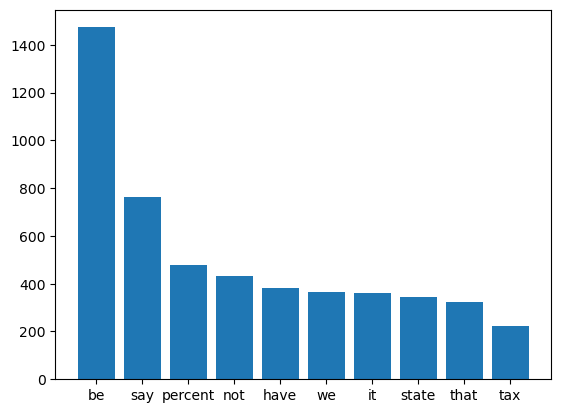

In [32]:
collection = create_collection(dfc,0,'statement-lemmatize')

dic=defaultdict(int)
for word in collection: 
    dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y)
plt.show()

Visualicación de las palabrás más comunes cuando es un bulo trás la lematización

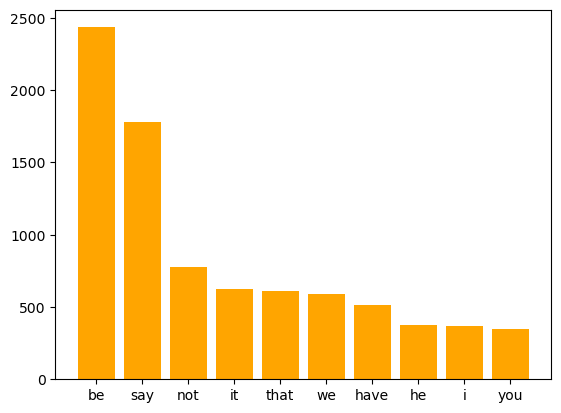

In [33]:
collection = create_collection(dfc,1,'statement-lemmatize')

dic=defaultdict(int)
for word in collection:
    if word in en_stopwords:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y,color='orange')
plt.show()

#### NER

Pasos realizados por la función ***preprocess_new***: 

1. <u>Limpieza inicial del texto</u>:

Elimina espacios en blanco adicionales y recorta los espacios al inicio y al final del texto utilizando re.sub(r'\s+', ' ', text).strip().

2. <u>Tokenización y análisis con SpaCy</u>:

Convierte el texto en un objeto doc utilizando el modelo de lenguaje SpaCy (nlp), lo que permite identificar las entidades nombradas.

3. <u>Extracción de entidades nombradas</u>:

Recolecta las entidades nombradas (ent.text) detectadas por SpaCy en el texto y las almacena en una lista llamada labels.

4. <u>Construcción de la salida</u>:

Si se detectan entidades nombradas, las une en una cadena separada por espacios.
Si no se detectan entidades, devuelve la cadena (no entities).

5. <u>Retorno del resultado</u>:

Devuelve una cadena con las entidades nombradas o (no entities) si no se encontraron.

In [34]:
def preprocess_ner(text):
    """
    Extrae las entidades nombradas y devuelve
    una cadena con sus labels en orden.
    """
    # Limpieza básica de espacios
    text = re.sub(r'\s+', ' ', text).strip()
    doc = nlp(text)

    # Recolectamos solo los labels, en orden de aparición
    labels = [ent.text for ent in doc.ents]

    # Unimos en una frase (puedes cambiar el separador si prefieres comas)
    if labels:
        return ' '.join(labels)
    else:
        return '(no entities)'

if __name__ == "__main__":
    ejemplos = [
        # "Says 76 percent voters United States want Johnson Weld presidential debates",
        "Barack Obama was born in Hawaii and served as President of the United States.",
        # "Apple Inc. announced a new iPhone in Cupertino."
        # "says her representation ex boyfriend who was my friend family law case is something that lawyers do regular basis",
    ]

    for s in ejemplos:
        frase_labels = preprocess_ner(s)
        print(f"Input:    {s}")
        print(f"Labels:   {frase_labels}\n")


Input:    Barack Obama was born in Hawaii and served as President of the United States.
Labels:   Barack Obama Hawaii the United States



Aplicar la función de ***preprocess_ner*** extrayendo palabras de valor a la columna *'statement'* del dataset y lo guardamos en *'statement-ner'*

In [35]:
# preprocess_ner
dfc['statement-ner'] = df['statement'].apply(lambda x: preprocess_ner(x))
dfc['statement-ner'] = dfc['statement-ner'].str.lower()


Creación de json para visualizarlo de manera más sencilla

In [36]:
statement_counts_dict = dfc['statement-ner'].to_dict()

create_json('json/json-study-statement/statements_ner.json', statement_counts_dict)

####  Sentimientos

Descargar el lexico de vader.

Crear una instacia del analizador de vader para utilizarlo luego.

In [37]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/sergio/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Función para a través de la instancia de vader analizar el sentimiento de los textos

In [38]:
def analyze_sentiment(text):
    return sia.polarity_scores(text)['compound']

if __name__ == "__main__":

    ejemplos = [
        "Barack Obama was born in Hawaii and served as President of the United States.",
    ]

    for s in ejemplos:
        print(f"Original: {s}")
        resultado = analyze_sentiment(s)
        print(f"Procesado: {resultado}\n")




Original: Barack Obama was born in Hawaii and served as President of the United States.
Procesado: 0.4215



Aplicar la función de ***analyze_sentiment*** para analizar los sentimientos a la columna *'statement'* del dataset y lo guardamos en *'feelings'*

In [39]:
dfc['feelings'] = df["statement"]
dfc['feelings'] = dfc["feelings"].apply(lambda x: analyze_sentiment(x))

Creación de json para visualizarlo de manera más sencilla

In [40]:
statement_counts_dict = dfc['feelings'].to_dict()

create_json('json/json-study-statement/statements_sentimientos.json', statement_counts_dict)

### 4.3.2 Resto de features

In [41]:
# dfc = data.copy()

#### - subject

Ver tipos de temáticas y como están almacenadas

In [42]:
dfc['subject'].value_counts()

subject
health-care                                                                                           341
taxes                                                                                                 244
elections                                                                                             225
immigration                                                                                           224
education                                                                                             201
                                                                                                     ... 
federal-budget,pundits,taxes,abc-news-week                                                              1
city-government,county-government,criminal-justice,job-accomplishments,legal-issues,public-service      1
campaign-finance,energy,oil-spill,pundits                                                               1
financial-regulation,guns             

Ver tipos de temáticas y como están almacenadas de las primeras 10 lineas del *dataset*

In [43]:
dfc['subject'].iloc[1:10]                    

1                                          health-care
2             corporations,pundits,taxes,abc-news-week
3    candidates-biography,children,ethics,families,...
4                       health-care,labor,state-budget
5                                 candidates-biography
6                     legal-issues,state-budget,states
7                                                 iraq
8                                          immigration
9     economy,income,retirement,social-security,wealth
Name: subject, dtype: object

Formatear bien las temáticas más almacenarlas en una lista para luego poder manipular los diferentes tópicos

In [44]:
dfc['subject'] = dfc['subject'].str.lower()
dfc['subject_list'] = (
    dfc['subject']
    .str.split(',')
    .apply(lambda lst: [s.strip() for s in lst if s.strip()])
)


*Explode* para tener una fila por cada etiqueta 

In [45]:
subjects_exploded = dfc.explode('subject_list')
subjects_exploded['subject_list'].iloc[1:10]

0          foreign-policy
0                military
1             health-care
2            corporations
2                 pundits
2                   taxes
2           abc-news-week
3    candidates-biography
3                children
Name: subject_list, dtype: object

Creación de json para visualizarlo de manera más sencilla

In [46]:
subject_count_dict = subjects_exploded['subject_list'].value_counts().to_dict()
with open('json/json-study/subject_counts.json', 'w', encoding='utf-8') as f:
    json.dump(subject_count_dict, f, ensure_ascii=False, indent=2)

Diccionario para mapear las diferntes temáticas en otrás categorías más genéricas

In [47]:
subject_mapping = {
    # economia_y_finanzas
    "economy": "subject-economia_y_finanzas",
    "taxes": "subject-economia_y_finanzas",
    "federal-budget": "subject-economia_y_finanzas",
    "state-budget": "subject-economia_y_finanzas",
    "income": "subject-economia_y_finanzas",
    "debt": "subject-economia_y_finanzas",
    "deficit": "subject-economia_y_finanzas",
    "market-regulation": "subject-economia_y_finanzas",
    "corporations": "subject-economia_y_finanzas",
    "stimulus": "subject-economia_y_finanzas",
    "small-business": "subject-economia_y_finanzas",
    "bankruptcy": "subject-economia_y_finanzas",
    "government-regulation": "subject-economia_y_finanzas",
    "financial-regulation": "subject-economia_y_finanzas",
    "housing": "subject-economia_y_finanzas",
    "agriculture": "subject-economia_y_finanzas",
    "poverty": "subject-economia_y_finanzas",
    "retirement": "subject-economia_y_finanzas",
    "pensions": "subject-economia_y_finanzas",

    # salud_y_bienestar
    "health-care": "subject-salud_y_bienestar",
    "medicare": "subject-salud_y_bienestar",
    "medicaid": "subject-salud_y_bienestar",
    "public-health": "subject-salud_y_bienestar",
    "disability": "subject-salud_y_bienestar",
    "drugs": "subject-salud_y_bienestar",
    "abortion": "subject-salud_y_bienestar",
    "hunger": "subject-salud_y_bienestar",
    "ebola": "subject-salud_y_bienestar",
    "autism": "subject-salud_y_bienestar",
    "marijuana": "subject-salud_y_bienestar",
    "welfare": "subject-salud_y_bienestar",

    # Educación
    "education": "subject-educacion",
    "children": "subject-educacion",

    # trabajo_y_empleo
    "jobs": "subject-trabajo_y_empleo",
    "labor": "subject-trabajo_y_empleo",
    "workers": "subject-trabajo_y_empleo",
    "unions": "subject-trabajo_y_empleo",
    "job-accomplishments": "subject-trabajo_y_empleo",

    # Política y Gobierno
    "elections": "subject-politica_y_gobierno",
    "candidates-biography": "subject-politica_y_gobierno",
    "congress": "subject-politica_y_gobierno",
    "state-finances": "subject-politica_y_gobierno",
    "city-government": "subject-politica_y_gobierno",
    "county-government": "subject-politica_y_gobierno",
    "campaign-finance": "subject-politica_y_gobierno",
    "voting-record": "subject-politica_y_gobierno",
    "transparency": "subject-politica_y_gobierno",
    "debates": "subject-politica_y_gobierno",
    "redistricting": "subject-politica_y_gobierno",
    "congressional-rules": "subject-politica_y_gobierno",
    "polls": "subject-politica_y_gobierno",
    "government-efficiency": "subject-politica_y_gobierno",
    "campaign-advertising": "subject-politica_y_gobierno",
    "bipartisanship": "subject-politica_y_gobierno",
    "infrastructure": "subject-politica_y_gobierno",
    "transportation": "subject-politica_y_gobierno",
    "message-machine": "subject-politica_y_gobierno",
    "message-machine-2012": "subject-politica_y_gobierno",
    "message-machine-2014": "subject-politica_y_gobierno",
    "states": "subject-politica_y_gobierno",

    # Seguridad y Justicia
    "crime": "subject-seguridad_y_justicia",
    "criminal-justice": "subject-seguridad_y_justicia",
    "legal-issues": "subject-seguridad_y_justicia",
    "public-safety": "subject-seguridad_y_justicia",
    "death-penalty": "subject-seguridad_y_justicia",
    "terrorism": "subject-seguridad_y_justicia",
    "homeland-security": "subject-seguridad_y_justicia",
    "supreme-court": "subject-seguridad_y_justicia",
    "consumer-safety": "subject-seguridad_y_justicia",
    "privacy": "subject-seguridad_y_justicia",
    "guns": "subject-seguridad_y_justicia",
    "social-security": "subject-seguridad_y_justicia",

    # Relaciones Internacionales
    "foreign-policy": "subject-relaciones_internacionales",
    "military": "subject-relaciones_internacionales",
    "iraq": "subject-relaciones_internacionales",
    "afghanistan": "subject-relaciones_internacionales",
    "china": "subject-relaciones_internacionales",
    "israel": "subject-relaciones_internacionales",
    "trade": "subject-relaciones_internacionales",
    "nuclear": "subject-relaciones_internacionales",
    "islam": "subject-relaciones_internacionales",

    # Medio Ambiente y Energía
    "energy": "subject-medio_ambiente_y_energia",
    "climate-change": "subject-medio_ambiente_y_energia",
    "oil-spill": "subject-medio_ambiente_y_energia",
    "environment": "subject-medio_ambiente_y_energia",
    "water": "subject-medio_ambiente_y_energia",
    "cap-and-trade": "subject-medio_ambiente_y_energia",
    "natural-disasters": "subject-medio_ambiente_y_energia",

    # Sociedad y Cultura
    "religion": "subject-sociedad_y_cultura",
    "gays-and-lesbians": "subject-sociedad_y_cultura",
    "women": "subject-sociedad_y_cultura",
    "families": "subject-sociedad_y_cultura",
    "marriage": "subject-sociedad_y_cultura",
    "civil-rights": "subject-sociedad_y_cultura",
    "immigration": "subject-sociedad_y_cultura",
    "diversity": "subject-sociedad_y_cultura",
    "sexuality": "subject-sociedad_y_cultura",
    "ethics": "subject-sociedad_y_cultura",
    "history": "subject-sociedad_y_cultura",
    "pundits": "subject-sociedad_y_cultura",
    "human-rights": "subject-sociedad_y_cultura",
    "pop-culture": "subject-sociedad_y_cultura",
    "colbert-report": "subject-sociedad_y_cultura",
    "population": "subject-sociedad_y_cultura",

    # Ciencia y Tecnología
    "science": "subject-ciencia_y_tecnologia",
    "space": "subject-ciencia_y_tecnologia",

    # Otros / Misceláneos
    "sports": "subject-otros",
    "fake-news": "subject-otros",
    "food": "subject-otros",
    "baseball": "subject-otros",
    "recreation": "subject-otros",
    "weather": "subject-otros",
    "food-safety": "subject-otros",
    "patriotism": "subject-otros",
    "nightlife": "subject-otros",
    "lottery": "subject-otros",
    "after-the-fact": "subject-otros",
    "urban": "subject-otros",
    "animals": "subject-otros",
    "gambling": "subject-otros",
    "alcohol": "subject-otros",
    "tourism": "subject-otros",
    "census": "subject-otros",
    "homeless": "subject-otros",
    "veterans": "subject-otros",
    "wealth": "subject-otros",
    "county-budget": "subject-otros",
    "city-budget": "subject-otros",
    "new-hampshire-2012": "subject-otros",
    "sotomayor-nomination": "subject-otros",
    "kagan-nomination": "subject-otros",
    "occupy-wall-street": "subject-otros",
    "florida": "subject-otros",
    "florida-amendments": "subject-otros",
    "public-service": "subject-otros",
    "gas-prices": "subject-otros",
    "bush-administration": "subject-otros",
    "obama-birth-certificate": "subject-otros",
    "10-news-tampa-bay": "subject-otros",
    "abc-news-week": "subject-otros",
    "corrections-and-updates": "subject-otros",
}


Aplicar el mapeo de las temáticas y categorizarlas al *dataset*

In [48]:
# # Aplicamos el mapeo al DataFrame
# subjects_exploded['subject_category'] = subjects_exploded['subject_list'].map(subject_mapping).fillna('subject-otros')

# # Obtenemos los conteos por nueva categoría
# category_counts = subjects_exploded['subject_category'].value_counts()

# print(category_counts)
# subjects_exploded['subject_category'].iloc[1:10]

Aplicar el mapeo de las temáticas y categorizarlas al *dataset*

In [49]:
dfc['subject_categories'] = dfc['subject_list'].apply(
    lambda lst: list({
        subject_mapping.get(s, 'subject-otros') 
        for s in lst
    })
)

print(dfc[['subject_list','subject_categories']].head())

                                        subject_list  \
0                  [china, foreign-policy, military]   
1                                      [health-care]   
2      [corporations, pundits, taxes, abc-news-week]   
3  [candidates-biography, children, ethics, famil...   
4                 [health-care, labor, state-budget]   

                                  subject_categories  
0               [subject-relaciones_internacionales]  
1                        [subject-salud_y_bienestar]  
2  [subject-sociedad_y_cultura, subject-otros, su...  
3  [subject-sociedad_y_cultura, subject-educacion...  
4  [subject-economia_y_finanzas, subject-salud_y_...  


One-Hot Binarizer sobre la lista de categorías 

In [50]:
mlb = MultiLabelBinarizer()
onehot = mlb.fit_transform(dfc['subject_categories'])

df_onehot = pd.DataFrame(
    onehot,
    columns=mlb.classes_,
    index=dfc.index
)

dfc = pd.concat([dfc, df_onehot], axis=1)

dfc.head()

,id,label,statement,subject,speaker,speaker_job,state_info,party_affiliation,statement-raw,statement-lemmatize,statement-ner,feelings,subject_list,subject_categories,subject-ciencia_y_tecnologia,subject-economia_y_finanzas,subject-educacion,subject-medio_ambiente_y_energia,subject-otros,subject-politica_y_gobierno,subject-relaciones_internacionales,subject-salud_y_bienestar,subject-seguridad_y_justicia,subject-sociedad_y_cultura,subject-trabajo_y_empleo
0,81f884c64a7,1,China is in the South China Sea and (building)...,"china,foreign-policy,military",donald-trump,President-Elect,New York,republican,china is south china sea military fortress lik...,china be south china sea military fortress lik...,china south china sea,0.4215,"[china, foreign-policy, military]",[subject-relaciones_internacionales],0,0,0,0,0,0,1,0,0,0,0
1,30c2723a188,0,With the resources it takes to execute just ov...,health-care,chris-dodd,U.S. senator,Connecticut,democrat,resources it takes execute months iraq war we ...,resources it take execute months iraq war we f...,just over three months the iraq war bush,-0.4767,[health-care],[subject-salud_y_bienestar],0,0,0,0,0,0,0,1,0,0,0
2,6936b216e5d,0,The (Wisconsin) governor has proposed tax give...,"corporations,pundits,taxes,abc-news-week",donna-brazile,Political commentator,"Washington, D.C.",democrat,wisconsin governor proposed tax giveaways corp...,wisconsin governor propose tax giveaways corpo...,wisconsin,0.0000,"[corporations, pundits, taxes, abc-news-week]","[subject-sociedad_y_cultura, subject-otros, su...",0,1,0,0,1,0,0,0,0,1,0
3,b5cd9195738,1,Says her representation of an ex-boyfriend who...,"candidates-biography,children,ethics,families,...",rebecca-bradley,NaN,NaN,none,says her representation ex boyfriend who was m...,say her representation ex boyfriend who be my ...,(no entities),0.4939,"[candidates-biography, children, ethics, famil...","[subject-sociedad_y_cultura, subject-educacion...",0,0,1,0,0,1,0,0,1,1,0
4,84f8dac7737,0,At protests in Wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,NaN,Wisconsin,republican,protests wisconsin proposed collective bargain...,protests wisconsin propose collective bargaini...,wisconsin,-0.5994,"[health-care, labor, state-budget]","[subject-economia_y_finanzas, subject-salud_y_...",0,1,0,0,0,0,0,1,0,0,1


Visualizar todas las columnas para comprobar que se han creado correctamente

In [51]:
print(dfc.columns)

Index(['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job',
       'state_info', 'party_affiliation', 'statement-raw',
       'statement-lemmatize', 'statement-ner', 'feelings', 'subject_list',
       'subject_categories', 'subject-ciencia_y_tecnologia',
       'subject-economia_y_finanzas', 'subject-educacion',
       'subject-medio_ambiente_y_energia', 'subject-otros',
       'subject-politica_y_gobierno', 'subject-relaciones_internacionales',
       'subject-salud_y_bienestar', 'subject-seguridad_y_justicia',
       'subject-sociedad_y_cultura', 'subject-trabajo_y_empleo'],
      dtype='object')


#### - speaker

Creación de json para visualizarlo de manera más sencilla

In [52]:
# Crear value counts 
speaker_counts = dfc['speaker'].value_counts()
speaker_counts_test = df_test['speaker'].value_counts()

# Convertir a diccionario
speaker_counts_dict = speaker_counts.to_dict()
speaker_counts_test_dict = speaker_counts_test.to_dict()

# Exportar a un archivo JSON
create_json('json/json-study/speaker_counts.json', speaker_counts_dict)
create_json('json/json-study/speaker_counts_test.json', speaker_counts_test_dict)

Utilizando los archivos JSON json-study/speaker_counts_test.json y json-study/speaker_counts_test.json, que contienen los conteos de apariciones de cada speaker tanto en el conjunto de entrenamiento como en el de prueba, se ha obtenido la lista de los 20 speakers más frecuentes en el conjunto de prueba.

Al analizar dicha lista, se observa que a partir del décimo speaker se produce una disminución significativa en la frecuencia de aparición. Por tanto, este punto podría considerarse un umbral razonable para realizar un corte: mantener los 10 speakers más frecuentes como categorías individuales y agrupar el resto bajo una categoría común, como "other_speakers". Esta decisión busca reducir el riesgo de overfitting y mejorar la capacidad de generalización del modelo.

<small>

| ID  | Name               | dfc | df_test |
|-----|--------------------|-----|---------|
| 1   | barack-obama       | 435 | 176     |
| 2   | donald-trump       | 247 | 96      |
| 3   | hillary-clinton    | 204 | 93      |
| 4   | mitt-romney        | 142 | 70      |
| 5   | john-mccain        | 139 | 50      |
| 6   | chain-email        | 128 | 50      |
| 7   | scott-walker       | 123 | 60      |
| 8   | rick-perry         | 117 | 56      |
| 9   | rick-scott         | 105 | 45      |
| 10  | marco-rubio        | 99  | 54      |
| 11  | ted-cruz           | 82  | 36      |
| 12  | bernie-s           | 75  | 31      |
| 13  | facebook-posts     | 75  | 25      |
| 14  | chris-christie     | 74  | 30      |
| 15  | charlie-crist      | 62  | 28      |
| 16  | newt-gingrich      | 62  | 21      |
| 17  | jeb-bush           | 60  | 19      |
| 18  | blog-posting       | 57  | 24      |
| 19  | joe-biden          | 54  | 22      |
| 20  | paul-ryan          | 50  | 20      |

</small>


Selección de los 10 *speakers* que más aparecen

In [53]:
top_n = 10
frequent_speakers = set(speaker_counts.head(top_n).index)

Meter en *grouped* los *speakers* más frecuentes y los demás guardarlos como *'other_speakers'*

In [54]:
dfc['speaker_grouped'] = dfc['speaker'].apply(
    lambda s: s if s in frequent_speakers else 'other_speakers'
)

dfc['speaker_grouped'].value_counts()

speaker_grouped
other_speakers     7211
barack-obama        435
donald-trump        247
hillary-clinton     204
mitt-romney         142
john-mccain         139
chain-email         128
scott-walker        123
rick-perry          117
rick-scott          105
marco-rubio          99
Name: count, dtype: int64

Codifcar las varralbes de las columna speaker_grouped

In [55]:
dfc['speaker_grouped_cod'] = dfc['speaker_grouped'].astype('category').cat.codes.astype('int64')
dfc['speaker_grouped_cod'].value_counts()


speaker_grouped_cod
7     7211
0      435
2      247
3      204
6      142
4      139
1      128
10     123
8      117
9      105
5       99
Name: count, dtype: int64

Visualizar para comprobar que el proceso se ha hecho bien

In [56]:
dfc.head()

,id,label,statement,subject,speaker,speaker_job,state_info,party_affiliation,statement-raw,statement-lemmatize,statement-ner,feelings,subject_list,subject_categories,subject-ciencia_y_tecnologia,subject-economia_y_finanzas,subject-educacion,subject-medio_ambiente_y_energia,subject-otros,subject-politica_y_gobierno,subject-relaciones_internacionales,subject-salud_y_bienestar,subject-seguridad_y_justicia,subject-sociedad_y_cultura,subject-trabajo_y_empleo,speaker_grouped,speaker_grouped_cod
0,81f884c64a7,1,China is in the South China Sea and (building)...,"china,foreign-policy,military",donald-trump,President-Elect,New York,republican,china is south china sea military fortress lik...,china be south china sea military fortress lik...,china south china sea,0.4215,"[china, foreign-policy, military]",[subject-relaciones_internacionales],0,0,0,0,0,0,1,0,0,0,0,donald-trump,2
1,30c2723a188,0,With the resources it takes to execute just ov...,health-care,chris-dodd,U.S. senator,Connecticut,democrat,resources it takes execute months iraq war we ...,resources it take execute months iraq war we f...,just over three months the iraq war bush,-0.4767,[health-care],[subject-salud_y_bienestar],0,0,0,0,0,0,0,1,0,0,0,other_speakers,7
2,6936b216e5d,0,The (Wisconsin) governor has proposed tax give...,"corporations,pundits,taxes,abc-news-week",donna-brazile,Political commentator,"Washington, D.C.",democrat,wisconsin governor proposed tax giveaways corp...,wisconsin governor propose tax giveaways corpo...,wisconsin,0.0000,"[corporations, pundits, taxes, abc-news-week]","[subject-sociedad_y_cultura, subject-otros, su...",0,1,0,0,1,0,0,0,0,1,0,other_speakers,7
3,b5cd9195738,1,Says her representation of an ex-boyfriend who...,"candidates-biography,children,ethics,families,...",rebecca-bradley,NaN,NaN,none,says her representation ex boyfriend who was m...,say her representation ex boyfriend who be my ...,(no entities),0.4939,"[candidates-biography, children, ethics, famil...","[subject-sociedad_y_cultura, subject-educacion...",0,0,1,0,0,1,0,0,1,1,0,other_speakers,7
4,84f8dac7737,0,At protests in Wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,NaN,Wisconsin,republican,protests wisconsin proposed collective bargain...,protests wisconsin propose collective bargaini...,wisconsin,-0.5994,"[health-care, labor, state-budget]","[subject-economia_y_finanzas, subject-salud_y_...",0,1,0,0,0,0,0,1,0,0,1,other_speakers,7


#### - speaker_job

Formatear de manera adecuada el contenido de la columna *'speaker_job'*

In [57]:
dfc['speaker_job'] = (
    dfc['speaker_job']
    .str.lower()
    .str.strip()
    .str.replace(r'\s+', '_', regex=True)  # Reemplazar espacios por guiones bajos
    .str.replace(r'\.', '', regex=True)   # Eliminar los puntos
)

df_test['speaker_job'] = (
    df_test['speaker_job']
    .str.lower()
    .str.strip()
    .str.replace(r'\s+', '_', regex=True)  # Reemplazar espacios por guiones bajos
    .str.replace(r'\.', '', regex=True)   # Eliminar los puntos
)

Creación de json para visualizarlo de manera más sencilla

In [58]:
# Obtener el conteo de valores únicos de 'speaker'
speaker_job_counts = dfc['speaker_job'].value_counts()
speaker_job_counts_test = df_test['speaker_job'].value_counts()


# Convertir a diccionario
speaker_job_counts_dict = speaker_job_counts.to_dict()
speaker_job_counts_test_dict = speaker_job_counts_test.to_dict()

# Exportar a un archivo JSON
create_json('json/json-study/speaker_job_counts.json', speaker_job_counts_dict)
create_json('json/json-study/speaker_job_counts_test.json', speaker_job_counts_test_dict)

Utilizando los archivos JSON json-study/speaker__job_counts_test.json y json-study/speaker_job_counts_test.json, que contienen los conteos de apariciones de cada speaker_job tanto en el conjunto de entrenamiento como en el de prueba, se ha obtenido la lista de los 20 speakers_jobs más frecuentes en el conjunto de prueba.

Al analizar dicha lista, se observa que a partir del treceavo speaker_job se produce una disminución significativa en la frecuencia de aparición. Por tanto, este punto podría considerarse un umbral razonable para realizar un corte: mantener los 13 speakers_jobs más frecuentes como categorías individuales y agrupar el resto bajo una categoría común, como "other_speakers_job". Esta decisión busca reducir el riesgo de overfitting y mejorar la capacidad de generalización del modelo.

<small>

| id  | speaker_job                                | train_count | test_count |
|-----|--------------------------------------------|-------------|------------|
| 1   | u_s__senator                               | 627         | 204        |
| 2   | president                                  | 438         | 177        |
| 3   | governor                                   | 368         | 152        |
| 4   | u_s__representative                        | 260         | 61         |
| 5   | president-elect                            | 247         | 96         |
| 6   | presidential_candidate                     | 216         | 99         |
| 7   | state_senator                              | 186         | 36         |
| 8   | state_representative                       | 155         | 30         |
| 9   | former_governor                            | 143         | 70         |
| 10  | senator                                    | 129         | 64         |
| 11  | milwaukee_county_executive                 | 123         | 60         |
| 12  | attorney                                   | 94          | 32         |
| 13  | u_s__house_of_representatives              | 81          | 37         |
| 14  | social_media_posting                       | 75          | 25         |
| 15  | governor_of_new_jersey                     | 74          | 30         |
| 16  | congressman                                | 70          | 38         |
| 17  | co-host_on_cnn_s__crossfire                | 66          | 22         |
| 18  | u_s__congressman                           | 56          | 26         |
| 19  | speaker_of_the_house_of_representatives    | 49          | 23         |
| 20  | congresswoman                              | 49          | 18         |

</small>


Extraer los *'speaker_jobs'* más frecuentes

In [59]:
# # Elegir el punto de corte (por ejemplo, los 10 más frecuentes)
# top_n = 13
# frequent_speaker_jobs = set(speaker_job_counts.head(top_n).index)

Diccionario para mapear las diferntes speaker_jobs en otrás categorías más genéricas

In [60]:
mapping_speaker_job_en = {
    "us_senator": "federal_legislator_senate",
    "president": "president",
    "governor": "governor",
    "us_representative": "federal_legislator_house",
    "president-elect": "president",
    "presidential_candidate": "presidential_candidate",
    "state_senator": "state_legislator_senate",
    "state_representative": "state_legislator_house",
    "former_governor": "governor",
    "senator": "federal_legislator_senate",  # Assuming federal context in absence of "state"
    "milwaukee_county_executive": "local_executive",
    "attorney": "legal_professional",
    "us_house_of_representatives": "federal_legislator_house",
    "social_media_posting": "public_communicator",  # Could be refined to "non_traditional_communicator" if relevant
    "governor_of_new_jersey": "governor",
    "congressman": "federal_legislator_house",
    "co-host_on_cnn's_\"crossfire\"": "public_communicator",
    "us_congressman": "federal_legislator_house",
    "congresswoman": "federal_legislator_house",
    "speaker_of_the_house_of_representatives": "federal_legislative_leader",
    "businessman": "business_professional",
    "governor_of_ohio_as_of_jan_10,_2011": "governor",
    "author": "public_communicator",
    "lawyer": "legal_professional",
    "candidate_for_us_senate_and_physician": "federal_legislative_candidate",
    "us_senator_from_ohio": "federal_legislator_senate",
    "lieutenant_governor": "state_executive",
    "house_majority_leader": "federal_legislative_leader",
    "us_representative,_florida_district_23": "federal_legislator_house",
    "consultant": "political_advisor",
    "mayor_of_providence": "local_executive",
    "former_president": "president",
    "columnist": "public_communicator",
    "political_action_committee": "political_organization",
    "radio_host": "public_communicator",
    "madison_school_board_member": "local_education_official",
    "secretary_of_state": "state_executive",
    "attorney_general": "state_executive",
    "us_house_member": "federal_legislator_house",
    "msnbc_host": "public_communicator",
    "senate_democratic_leader": "federal_legislative_leader",
    "senate_minority_leader": "federal_legislative_leader",
    "ohio_treasurer": "state_executive",
    "state_assemblyman": "state_legislator_house",
    "chairman,_republican_national_committee": "party_leader",
    "us_representative,_florida_district_22": "federal_legislator_house",
    "house_minority_leader": "federal_legislative_leader",
    "mayor_of_milwaukee": "local_executive",
    "lieutenant_governor-elect": "state_executive",
    "philanthropist": "public_communicator" # Could be considered "influencer" or "social_actor"
}

Agrupar por categorías en función del diccionario

In [61]:
# Combinar las dos operaciones
dfc['speaker_job_grouped'] = dfc['speaker_job'].map(mapping_speaker_job_en)
dfc['speaker_job_grouped'].value_counts()

speaker_job_grouped
federal_legislator_senate        795
president                        712
governor                         630
federal_legislator_house         590
public_communicator              276
presidential_candidate           216
state_legislator_senate          186
state_legislator_house           175
local_executive                  172
federal_legislative_leader       147
legal_professional               134
state_executive                  124
business_professional             46
federal_legislative_candidate     40
political_advisor                 31
political_organization            27
local_education_official          25
party_leader                      19
Name: count, dtype: int64

Rellenar si hay algún speaker que tenga categória en alguna fila que en otra no tenga

In [62]:
dfc['speaker_job_grouped'] = dfc.groupby('speaker')['speaker_job_grouped'].transform(
    lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x
)

dfc['speaker_job_grouped'].value_counts()

speaker_job_grouped
federal_legislator_senate        795
president                        712
governor                         630
federal_legislator_house         590
public_communicator              276
presidential_candidate           216
state_legislator_senate          186
state_legislator_house           175
local_executive                  172
federal_legislative_leader       147
legal_professional               134
state_executive                  124
business_professional             46
federal_legislative_candidate     40
political_advisor                 31
political_organization            27
local_education_official          25
party_leader                      19
Name: count, dtype: int64

Rellenar los null con other_speaker_job

In [63]:
dfc['speaker_job_grouped'] = dfc['speaker_job_grouped'].fillna('other_speaker_job')

# Verificar el resultado
dfc['speaker_job_grouped'].value_counts()


speaker_job_grouped
other_speaker_job                4605
federal_legislator_senate         795
president                         712
governor                          630
federal_legislator_house          590
public_communicator               276
presidential_candidate            216
state_legislator_senate           186
state_legislator_house            175
local_executive                   172
federal_legislative_leader        147
legal_professional                134
state_executive                   124
business_professional              46
federal_legislative_candidate      40
political_advisor                  31
political_organization             27
local_education_official           25
party_leader                       19
Name: count, dtype: int64

Codificación de las variables de speaker_job

In [64]:
dfc['speaker_job_grouped_cod'] = dfc['speaker_job_grouped'].astype('category').cat.codes.astype('int64')
dfc['speaker_job_grouped_cod'].value_counts()


speaker_job_grouped_cod
9     4605
4      795
13     712
5      630
3      590
15     276
14     216
18     186
17     175
8      172
2      147
6      134
16     124
0       46
1       40
11      31
12      27
7       25
10      19
Name: count, dtype: int64

Visualización para comprobar

In [65]:
dfc.head()

,id,label,statement,subject,speaker,speaker_job,state_info,party_affiliation,statement-raw,statement-lemmatize,statement-ner,feelings,subject_list,subject_categories,subject-ciencia_y_tecnologia,subject-economia_y_finanzas,subject-educacion,subject-medio_ambiente_y_energia,subject-otros,subject-politica_y_gobierno,subject-relaciones_internacionales,subject-salud_y_bienestar,subject-seguridad_y_justicia,subject-sociedad_y_cultura,subject-trabajo_y_empleo,speaker_grouped,speaker_grouped_cod,speaker_job_grouped,speaker_job_grouped_cod
0,81f884c64a7,1,China is in the South China Sea and (building)...,"china,foreign-policy,military",donald-trump,president-elect,New York,republican,china is south china sea military fortress lik...,china be south china sea military fortress lik...,china south china sea,0.4215,"[china, foreign-policy, military]",[subject-relaciones_internacionales],0,0,0,0,0,0,1,0,0,0,0,donald-trump,2,president,13
1,30c2723a188,0,With the resources it takes to execute just ov...,health-care,chris-dodd,us_senator,Connecticut,democrat,resources it takes execute months iraq war we ...,resources it take execute months iraq war we f...,just over three months the iraq war bush,-0.4767,[health-care],[subject-salud_y_bienestar],0,0,0,0,0,0,0,1,0,0,0,other_speakers,7,federal_legislator_senate,4
2,6936b216e5d,0,The (Wisconsin) governor has proposed tax give...,"corporations,pundits,taxes,abc-news-week",donna-brazile,political_commentator,"Washington, D.C.",democrat,wisconsin governor proposed tax giveaways corp...,wisconsin governor propose tax giveaways corpo...,wisconsin,0.0000,"[corporations, pundits, taxes, abc-news-week]","[subject-sociedad_y_cultura, subject-otros, su...",0,1,0,0,1,0,0,0,0,1,0,other_speakers,7,other_speaker_job,9
3,b5cd9195738,1,Says her representation of an ex-boyfriend who...,"candidates-biography,children,ethics,families,...",rebecca-bradley,NaN,NaN,none,says her representation ex boyfriend who was m...,say her representation ex boyfriend who be my ...,(no entities),0.4939,"[candidates-biography, children, ethics, famil...","[subject-sociedad_y_cultura, subject-educacion...",0,0,1,0,0,1,0,0,1,1,0,other_speakers,7,other_speaker_job,9
4,84f8dac7737,0,At protests in Wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,NaN,Wisconsin,republican,protests wisconsin proposed collective bargain...,protests wisconsin propose collective bargaini...,wisconsin,-0.5994,"[health-care, labor, state-budget]","[subject-economia_y_finanzas, subject-salud_y_...",0,1,0,0,0,0,0,1,0,0,1,other_speakers,7,other_speaker_job,9


#### - state_info

Función para limipiar le contenido de la columna *state_info*

In [66]:
def clean_state_info(text):
    if isinstance(text, str):  # Verifica que el valor sea una cadena
        text = re.sub(r'[^\w\s]', '', text)  # Reemplaza cualquier carácter que no sea palabra o espacio
        return text.strip()  # Elimina espacios al principio y al final
    return text  # Devuelve el valor original si no es una cadena


Limpieza de los valores de la columna *state_info* y poner en minúscula

In [67]:
dfc['state_info'] = dfc['state_info'].str.lower()
dfc['state_info'] = dfc['state_info'].apply(clean_state_info)
df_test['state_info'] = df_test['state_info'].str.lower()
df_test['state_info'] = df_test['state_info'].apply(clean_state_info)

Creación de json para visualizarlo de manera más sencilla

In [68]:
# Obtener el conteo de valores únicos de 'speaker'
state_info_counts = dfc['state_info'].value_counts()
state_info_counts_test = df_test['state_info'].value_counts()


# Convertir a diccionario
state_info_counts_dict = state_info_counts.to_dict()
state_info_counts_test_dict = state_info_counts_test.to_dict()

# Exportar a un archivo JSON
create_json('json/json-study/state_info_counts.json', state_info_counts_dict)
create_json('json/json-study/state_info_counts_test.json', state_info_counts_test_dict)

| Número | Estado               | Train | Test |
|--------|----------------------|-------|------|
| 1      | Texas                | 879   | 380  |
| 2      | Florida              | 853   | 378  |
| 3      | Wisconsin            | 648   | 252  |
| 4      | New York             | 579   | 250  |
| 5      | Illinois             | 487   | 205  |
| 6      | Ohio                 | 408   | 178  |
| 7      | Georgia              | 381   | 164  |
| 8      | Virginia             | 368   | 144  |
| 9      | Rhode Island         | 317   | 135  |
| 10     | New Jersey           | 209   | 96   |
| 11     | Oregon               | 220   | 87   |
| 12     | Massachusetts        | 167   | 83   |
| 13     | Arizona              | 160   | 68   |
| 14     | California           | 121   | 59   |
| 15     | Washington, D.C.     | 89    | 52   |
| 16     | Vermont              | 80    | 37   |
| 17     | New Hampshire        | 79    | 28   |
| 18     | Pennsylvania         | 79    | 33   |
| 19     | Arkansas             | 77    | 26   |
| 20     | Kentucky             | 72    | 26   |


Utilizando los archivos JSON json-study/state_info_counts_test.json y json-study/state_info_counts.json, que contienen los conteos de apariciones de cada estado tanto en el conjunto de entrenamiento como en el de prueba, se ha obtenido la lista de los 20 estados más frecuentes en el conjunto de prueba.

Al analizar dicha lista, se observa que a partir del quinceavo estado se produce una disminución significativa en la frecuencia de aparición. Por tanto, este punto podría considerarse un umbral razonable para realizar un corte: mantener los 15 estados más frecuentes como categorías individuales y agrupar el resto bajo una categoría común, como "other_states". Esta decisión busca reducir el riesgo de overfitting y mejorar la capacidad de generalización del modelo.

Extraer los *states_info* más comunes

In [69]:
# Obtener el conteo de valores únicos de 'state_info'
state_info_counts = dfc['state_info'].value_counts()

# Elegir el punto de corte (por ejemplo, los 10 más frecuentes)
top_n = 15
frequent_state_info = set(state_info_counts.head(top_n).index)

Ver como se distribulle la frecuencia de las variables

In [70]:
dfc['state_info'].value_counts()

state_info
texas                879
florida              857
wisconsin            649
new york             580
illinois             489
                    ... 
china                  1
montana                1
atlanta                1
the united states      1
russia                 1
Name: count, Length: 61, dtype: int64

Rellenar si hay algún speaker que tenga state_info en alguna fila que en otra no tenga

In [71]:
dfc['state_info'] = dfc.groupby('speaker')['state_info'].transform(
    lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x
)

dfc['state_info'].value_counts()


state_info
texas                879
florida              857
wisconsin            649
new york             580
illinois             489
                    ... 
china                  1
montana                1
atlanta                1
the united states      1
russia                 1
Name: count, Length: 61, dtype: int64

Rellenar los nulos con *'other_state_info'*

In [72]:
# Agrupar los menos frecuentes como 'other_state_info'
dfc['state_info_grouped'] = dfc['state_info'].apply(
    lambda info: info if info in frequent_state_info else 'other_state_info'
)

# 6. Ver el resultado final
dfc['state_info_grouped'].value_counts()

state_info_grouped
other_state_info    3013
texas                879
florida              857
wisconsin            649
new york             580
illinois             489
ohio                 410
georgia              398
virginia             369
rhode island         319
oregon               222
new jersey           209
massachusetts        172
arizona              160
california           122
washington dc        102
Name: count, dtype: int64

Codificaión de las variables de state_info

In [73]:
dfc['state_info_grouped_cod'] = dfc['state_info_grouped'].astype('category').cat.codes.astype('int64')
dfc['state_info_grouped_cod'].value_counts()


state_info_grouped_cod
10    3013
12     879
2      857
15     649
7      580
4      489
8      410
3      398
13     369
11     319
9      222
6      209
5      172
0      160
1      122
14     102
Name: count, dtype: int64

Visualizción para comprobar

In [74]:
dfc.head()

,id,label,statement,subject,speaker,speaker_job,state_info,party_affiliation,statement-raw,statement-lemmatize,statement-ner,feelings,subject_list,subject_categories,subject-ciencia_y_tecnologia,subject-economia_y_finanzas,subject-educacion,subject-medio_ambiente_y_energia,subject-otros,subject-politica_y_gobierno,subject-relaciones_internacionales,subject-salud_y_bienestar,subject-seguridad_y_justicia,subject-sociedad_y_cultura,subject-trabajo_y_empleo,speaker_grouped,speaker_grouped_cod,speaker_job_grouped,speaker_job_grouped_cod,state_info_grouped,state_info_grouped_cod
0,81f884c64a7,1,China is in the South China Sea and (building)...,"china,foreign-policy,military",donald-trump,president-elect,new york,republican,china is south china sea military fortress lik...,china be south china sea military fortress lik...,china south china sea,0.4215,"[china, foreign-policy, military]",[subject-relaciones_internacionales],0,0,0,0,0,0,1,0,0,0,0,donald-trump,2,president,13,new york,7
1,30c2723a188,0,With the resources it takes to execute just ov...,health-care,chris-dodd,us_senator,connecticut,democrat,resources it takes execute months iraq war we ...,resources it take execute months iraq war we f...,just over three months the iraq war bush,-0.4767,[health-care],[subject-salud_y_bienestar],0,0,0,0,0,0,0,1,0,0,0,other_speakers,7,federal_legislator_senate,4,other_state_info,10
2,6936b216e5d,0,The (Wisconsin) governor has proposed tax give...,"corporations,pundits,taxes,abc-news-week",donna-brazile,political_commentator,washington dc,democrat,wisconsin governor proposed tax giveaways corp...,wisconsin governor propose tax giveaways corpo...,wisconsin,0.0000,"[corporations, pundits, taxes, abc-news-week]","[subject-sociedad_y_cultura, subject-otros, su...",0,1,0,0,1,0,0,0,0,1,0,other_speakers,7,other_speaker_job,9,washington dc,14
3,b5cd9195738,1,Says her representation of an ex-boyfriend who...,"candidates-biography,children,ethics,families,...",rebecca-bradley,NaN,NaN,none,says her representation ex boyfriend who was m...,say her representation ex boyfriend who be my ...,(no entities),0.4939,"[candidates-biography, children, ethics, famil...","[subject-sociedad_y_cultura, subject-educacion...",0,0,1,0,0,1,0,0,1,1,0,other_speakers,7,other_speaker_job,9,other_state_info,10
4,84f8dac7737,0,At protests in Wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,NaN,wisconsin,republican,protests wisconsin proposed collective bargain...,protests wisconsin propose collective bargaini...,wisconsin,-0.5994,"[health-care, labor, state-budget]","[subject-economia_y_finanzas, subject-salud_y_...",0,1,0,0,0,0,0,1,0,0,1,other_speakers,7,other_speaker_job,9,wisconsin,15


#### - party_affiliation

Creación de json para visualizarlo de manera más sencilla

In [75]:
# Obtener el conteo de valores únicos de 'speaker'
party_affiliation_counts = dfc['party_affiliation'].value_counts()
party_affiliation_counts_test = df_test['party_affiliation'].value_counts()


# Convertir a diccionario
party_affiliation_counts_dict = party_affiliation_counts.to_dict()
party_affiliation_counts_dict_test = party_affiliation_counts_test.to_dict()

# Exportar a un archivo JSON
create_json('json/json-study/party_affiliation_counts.json', party_affiliation_counts_dict)
create_json('json/json-study/party_affiliation_counts_test.json', party_affiliation_counts_dict_test)


Diccionario para mapear las diferernetes partidos en otrás categorías más genéricas

In [76]:
mapping = {
    # Major parties
    'republican': 'republican',
    'democrat': 'democrat',
    'democratic-farmer-labor': 'democrat',

    # Independents / None
    'none': 'independent_None',
    'independent': 'independent_None',

    # Media
    'newsmaker': 'media',
    'journalist': 'media',
    'columnist': 'media',
    'activist': 'media',
    'talk-show-host': 'media',
    
    # Third parties
    'libertarian': 'third_Party',
    'green': 'third_Party',
    'constitution-party': 'third_Party',
    'liberal-party-canada': 'third_Party',

    # Organizations
    'organization': 'organization',
    
    # Officials  
    'state-official': 'official',
    'business-leader': 'official',
    'labor-leader': 'official',
    'education-official': 'official',
    'government-body': 'official',

    # Tea Party
    'tea-party-member': 'republican',
    'ocean-state-tea-party-action': 'republican',
}

Función para agrupar partidos

In [77]:
def group_party(x):
    return mapping.get(x, 'other')  # anything else → 'Other'

Agrupación de los partidos del dataset por la función *group_party*

In [78]:
dfc['party_group'] = dfc['party_affiliation'].apply(group_party)

# Recuento de las nuevas categorías
print(dfc['party_group'].value_counts())


party_group
republican          3956
democrat            2899
independent_None    1661
organization         197
media                163
third_Party           40
official              32
other                  2
Name: count, dtype: int64


Codficiación de las variables de party_affiliation

In [79]:
dfc['party_group_cod'] = dfc['party_group'].astype('category').cat.codes.astype('int64')

Visualización para comprobación

In [80]:
dfc.head()

,id,label,statement,subject,speaker,speaker_job,state_info,party_affiliation,statement-raw,statement-lemmatize,statement-ner,feelings,subject_list,subject_categories,subject-ciencia_y_tecnologia,subject-economia_y_finanzas,subject-educacion,subject-medio_ambiente_y_energia,subject-otros,subject-politica_y_gobierno,subject-relaciones_internacionales,subject-salud_y_bienestar,subject-seguridad_y_justicia,subject-sociedad_y_cultura,subject-trabajo_y_empleo,speaker_grouped,speaker_grouped_cod,speaker_job_grouped,speaker_job_grouped_cod,state_info_grouped,state_info_grouped_cod,party_group,party_group_cod
0,81f884c64a7,1,China is in the South China Sea and (building)...,"china,foreign-policy,military",donald-trump,president-elect,new york,republican,china is south china sea military fortress lik...,china be south china sea military fortress lik...,china south china sea,0.4215,"[china, foreign-policy, military]",[subject-relaciones_internacionales],0,0,0,0,0,0,1,0,0,0,0,donald-trump,2,president,13,new york,7,republican,6
1,30c2723a188,0,With the resources it takes to execute just ov...,health-care,chris-dodd,us_senator,connecticut,democrat,resources it takes execute months iraq war we ...,resources it take execute months iraq war we f...,just over three months the iraq war bush,-0.4767,[health-care],[subject-salud_y_bienestar],0,0,0,0,0,0,0,1,0,0,0,other_speakers,7,federal_legislator_senate,4,other_state_info,10,democrat,0
2,6936b216e5d,0,The (Wisconsin) governor has proposed tax give...,"corporations,pundits,taxes,abc-news-week",donna-brazile,political_commentator,washington dc,democrat,wisconsin governor proposed tax giveaways corp...,wisconsin governor propose tax giveaways corpo...,wisconsin,0.0000,"[corporations, pundits, taxes, abc-news-week]","[subject-sociedad_y_cultura, subject-otros, su...",0,1,0,0,1,0,0,0,0,1,0,other_speakers,7,other_speaker_job,9,washington dc,14,democrat,0
3,b5cd9195738,1,Says her representation of an ex-boyfriend who...,"candidates-biography,children,ethics,families,...",rebecca-bradley,NaN,NaN,none,says her representation ex boyfriend who was m...,say her representation ex boyfriend who be my ...,(no entities),0.4939,"[candidates-biography, children, ethics, famil...","[subject-sociedad_y_cultura, subject-educacion...",0,0,1,0,0,1,0,0,1,1,0,other_speakers,7,other_speaker_job,9,other_state_info,10,independent_None,1
4,84f8dac7737,0,At protests in Wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,NaN,wisconsin,republican,protests wisconsin proposed collective bargain...,protests wisconsin propose collective bargaini...,wisconsin,-0.5994,"[health-care, labor, state-budget]","[subject-economia_y_finanzas, subject-salud_y_...",0,1,0,0,0,0,0,1,0,0,1,other_speakers,7,other_speaker_job,9,wisconsin,15,republican,6


#### - Drop columns

Eliminar columnas inecesarias

In [81]:
dfc.drop(columns='subject', inplace=True)
dfc.drop(columns='subject_list', inplace=True)
dfc.drop(columns='subject_categories', inplace=True)

dfc.drop(columns='speaker', inplace=True)
dfc.drop(columns='speaker_job', inplace=True)
dfc.drop(columns='state_info', inplace=True)
dfc.drop(columns='party_affiliation', inplace=True)


# 5. Create Test

In [82]:
dfa = df_test.copy() # Backup del dataframe original
dfa.dtypes.sort_index()

id                   object
party_affiliation    object
speaker              object
speaker_job          object
state_info           object
statement            object
subject              object
dtype: object

In [83]:
# Opcional: Eliminar filas con valores nulos en el DataFrame 'df_test'
# df_test = df_test.dropna()

# # Mostrar la cantidad de valores nulos restantes en 'df_test'
print(df_test.isnull().sum())

id                      0
statement               0
subject                 0
speaker                 0
speaker_job          1082
state_info            818
party_affiliation       0
dtype: int64


### - statements

Raw

In [84]:
dfa['statement'] = dfa['statement'].str.replace("Ill", "i'll")

dfa['statement'] = dfa.apply(lambda row: preprocess(row['statement'], row.name), axis=1)
dfa['statement-raw']  = dfa['statement']
# dfa['statement-raw'] = dfa['statement-raw'].apply(lambda x: x.lower())
dfa['statement-raw'] = dfa['statement-raw'].str.lower()

# Mostrar los contadores
print(f"URLs eliminadas: {url_changes}")
print(f"Puntuaciones eliminadas: {punct_changes}")
print(f"Stopwords eliminadas: {stopword_changes}")
print(f"Dígitos eliminados: {digit_changes}")

URLs eliminadas: 54
Puntuaciones eliminadas: 33336
Stopwords eliminadas: 68048
Dígitos eliminados: 11536


leamtize

In [85]:
dfa['statement-lemmatize'] = dfa['statement-raw'].apply(lambda x: lemmatize_verbs(x))
# dfa['statement-leamtize'] = dfa['statement-leamtize'].apply(lambda x: x.lower())

ner

In [86]:
dfa['statement-ner'] = df_test['statement'].apply(lambda x: preprocess_ner(x))
dfa['statement-ner'] = dfa['statement-ner'].str.lower()

sentimientos

In [87]:
dfa['feelings'] = df_test["statement"]
dfa['feelings'] = dfa["feelings"].apply(lambda x: analyze_sentiment(x))

### - subject

In [88]:
dfa['subject'] = dfa['subject'].str.lower()
dfa['subject_list'] = (
    dfa['subject']
    .str.split(',')
    .apply(lambda lst: [s.strip() for s in lst if s.strip()])
)

# --- 2) Mapea cada subject a su categoría y quita duplicados ---
dfa['subject_categories'] = dfa['subject_list'].apply(
    lambda lst: list({
        subject_mapping.get(s, 'subject-otros') 
        for s in lst
    })
)

# (Opcional) echa un vistazo:
print(dfa[['subject_list','subject_categories']].head())

# --- 3) One-Hot Binarizer sobre la lista de categorías ---
mlb = MultiLabelBinarizer()
onehot = mlb.fit_transform(dfa['subject_categories'])

# Construye el DataFrame de one-hot
dfa_onehot = pd.DataFrame(
    onehot,
    columns=mlb.classes_,
    index=dfa.index
)


dfa = pd.concat([dfa, dfa_onehot], axis=1)

print(dfa.shape)
dfa.head()


                                        subject_list  \
0  [campaign-finance, ethics, government-regulation]   
1                                        [elections]   
2          [health-care, immigration, public-health]   
3        [federal-budget, medicare, social-security]   
4               [federal-budget, new-hampshire-2012]   

                                  subject_categories  
0  [subject-sociedad_y_cultura, subject-economia_...  
1                      [subject-politica_y_gobierno]  
2  [subject-sociedad_y_cultura, subject-salud_y_b...  
3  [subject-seguridad_y_justicia, subject-salud_y...  
4       [subject-otros, subject-economia_y_finanzas]  
(3836, 24)


,id,statement,subject,speaker,speaker_job,state_info,party_affiliation,statement-raw,statement-lemmatize,statement-ner,feelings,subject_list,subject_categories,subject-ciencia_y_tecnologia,subject-economia_y_finanzas,subject-educacion,subject-medio_ambiente_y_energia,subject-otros,subject-politica_y_gobierno,subject-relaciones_internacionales,subject-salud_y_bienestar,subject-seguridad_y_justicia,subject-sociedad_y_cultura,subject-trabajo_y_empleo
0,dc32e5ffa8b,members Common Cause Georgia board accepted ma...,"campaign-finance,ethics,government-regulation",kasim-reed,NaN,NaN,democrat,members common cause georgia board accepted ma...,members common cause georgia board accept maxi...,five georgia,0.2732,"[campaign-finance, ethics, government-regulation]","[subject-sociedad_y_cultura, subject-economia_...",0,1,0,0,0,1,0,0,0,1,0
1,aa49bb41cab,There s not negative advertising my campaign,elections,bill-mccollum,NaN,florida,republican,there s not negative advertising my campaign,there s not negative advertising my campaign,(no entities),-0.7096,[elections],[subject-politica_y_gobierno],0,0,0,0,0,1,0,0,0,0,0
2,dddc8d12ac1,Leticia Van de Putte voted give illegal immigr...,"health-care,immigration,public-health",dan-patrick,lieutenant_governor-elect,texas,republican,leticia van de putte voted give illegal immigr...,leticia van de putte vote give illegal immigra...,leticia van de putte,0.8720,"[health-care, immigration, public-health]","[subject-sociedad_y_cultura, subject-salud_y_b...",0,0,0,0,0,0,0,1,0,1,0
3,bcfe8f51667,Fiorinas plan mean slashing Social Security Me...,"federal-budget,medicare,social-security",barbara-boxer,us_senator,california,democrat,fiorinas plan mean slashing social security me...,fiorinas plan mean slash social security medicare,fiorinas social security medicare,0.0772,"[federal-budget, medicare, social-security]","[subject-seguridad_y_justicia, subject-salud_y...",0,1,0,0,0,0,0,1,1,0,0
4,eedbbaff5ab,end his term President Obama added debt prior ...,"federal-budget,new-hampshire-2012",mitt-romney,former_governor,massachusetts,republican,end his term president obama added debt prior ...,end his term president obama add debt prior pr...,the end of his first obama 43,-0.3612,"[federal-budget, new-hampshire-2012]","[subject-otros, subject-economia_y_finanzas]",0,1,0,0,1,0,0,0,0,0,0


### - speaker

In [89]:
# 4. Agrupar los menos frecuentes como 'other_speakers'
dfa['speaker_grouped'] = dfa['speaker'].apply(
    lambda s: s if s in frequent_speakers else 'other_speakers'
)
dfa['speaker_grouped_cod'] = dfa['speaker_grouped'].astype('category').cat.codes.astype('int64')

dfa['speaker_grouped'].value_counts()

speaker_grouped
other_speakers     3086
barack-obama        176
donald-trump         96
hillary-clinton      93
mitt-romney          70
scott-walker         60
rick-perry           56
marco-rubio          54
john-mccain          50
chain-email          50
rick-scott           45
Name: count, dtype: int64

### - speaker_job

In [90]:
# Agrupar los menos frecuentes como 'other_speaker_jobs'
# dfa['speaker_job_grouped'] = dfa['speaker_job'].apply(
#     lambda job: job if job in frequent_speaker_jobs else 'other_speaker_jobs'
# )
dfa['speaker_job_grouped'] = dfa['speaker_job'].map(mapping_speaker_job_en)

dfa['speaker_job_grouped'] = dfa.groupby('speaker')['speaker_job_grouped'].transform(
    lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x
)
dfa['speaker_job_grouped'] = dfa['speaker_job_grouped'].fillna('other_speaker_job')


dfa['speaker_job_grouped_cod'] = dfa['speaker_job_grouped'].astype('category').cat.codes.astype('int64')

# Ver el resultado final
dfa['speaker_job_grouped'].value_counts()

speaker_job_grouped
other_speaker_job                1974
federal_legislator_senate         369
governor                          291
president                         287
federal_legislator_house          266
presidential_candidate             99
public_communicator                83
state_legislator_house             81
local_executive                    73
state_legislator_senate            71
federal_legislative_leader         59
state_executive                    57
legal_professional                 57
political_organization             15
business_professional              14
federal_legislative_candidate      12
political_advisor                  11
local_education_official            9
party_leader                        8
Name: count, dtype: int64

### - state_info

In [91]:
# Agrupar los menos frecuentes como 'other_state_info'
dfa['state_info_grouped'] = dfa['state_info'].apply(
    lambda info: info if info in frequent_state_info else 'other_state_info'
)

dfa['state_info_grouped_cod'] = dfa['state_info_grouped'].astype('category').cat.codes.astype('int64')

# 6. Ver el resultado final
dfa['state_info_grouped'].value_counts()

state_info_grouped
other_state_info    1283
florida              380
texas                380
wisconsin            253
new york             251
illinois             206
ohio                 179
georgia              168
virginia             144
rhode island         135
new jersey            96
oregon                88
massachusetts         84
arizona               68
california            62
washington dc         59
Name: count, dtype: int64

### - party_affiliation

In [92]:
dfa['party_group'] = dfa['party_affiliation'].apply(group_party)

# Recuento de las nuevas categorías
print(dfa['party_group'].value_counts())

dfa['party_group_cod'] = dfa['party_group'].astype('category').cat.codes.astype('int64')


party_group
republican          1718
democrat            1238
independent_None     700
media                 71
organization          67
official              23
third_Party           18
other                  1
Name: count, dtype: int64


In [93]:
dfa.drop(columns='subject', inplace=True)
dfa.drop(columns='subject_list', inplace=True)
dfa.drop(columns='subject_categories', inplace=True)
dfa.drop(columns='speaker', inplace=True)
dfa.drop(columns='speaker_job', inplace=True)
dfa.drop(columns='state_info', inplace=True)
dfa.drop(columns='party_affiliation', inplace=True)


# 6. Exportar CSV

Comparar los dos dataset para ver que todo esta bien

In [94]:
# Comparar las columnas de dfc y dfa
columns_dfc = set(dfc.columns)
columns_dfa = set(dfa.columns)

# Encontrar las diferencias
differences = columns_dfc.symmetric_difference(columns_dfa)

# Verificar si la única diferencia es 'id' y 'label'
if differences == {'id', 'label'}:
    print("La única diferencia entre las columnas es 'id' y 'label'.")
else:
    print("Existen otras diferencias en las columnas:", differences)
    print("Columnas en dfc pero no en dfa:", columns_dfc - columns_dfa)
    print("Columnas en dfa pero no en dfc:", columns_dfa - columns_dfc)

Existen otras diferencias en las columnas: {'label'}
Columnas en dfc pero no en dfa: {'label'}
Columnas en dfa pero no en dfc: set()


Guardar en *formated* los csv train y test

In [95]:
# Exportar el DataFrame 'dfn' a un archivo CSV
dfc.to_csv('./formated/train_exportado.csv', index=False)

dfa.to_csv('./formated/test_exportado.csv', index=False)

Todas las features:

In [96]:
df_train_f = pd.read_csv("formated/train_exportado.csv")
df_train_llm = pd.read_csv("formated/llm_train_backup.csv")

df_train_combined = pd.concat([df_train_f, df_train_llm], axis=1)
# print(df_train_combined.columns)
df_train_combined.to_csv('./formated/train_exportado.csv', index=False)




df_test_f = pd.read_csv("formated/test_exportado.csv")
df_test_llm = pd.read_csv("formated/llm_test_backup.csv")
df_test_combined = pd.concat([df_test_f, df_test_llm], axis=1)
# print(df_test_combined.columns)
df_test_combined.to_csv('./formated/test_exportado.csv', index=False)


# 7. Correlacion

In [97]:
df_train_c = pd.read_csv("formated/train_exportado.csv")

In [98]:
df_train_c.dtypes

id                                     object
label                                   int64
statement                              object
statement-raw                          object
statement-lemmatize                    object
statement-ner                          object
feelings                              float64
subject-ciencia_y_tecnologia            int64
subject-economia_y_finanzas             int64
subject-educacion                       int64
subject-medio_ambiente_y_energia        int64
subject-otros                           int64
subject-politica_y_gobierno             int64
subject-relaciones_internacionales      int64
subject-salud_y_bienestar               int64
subject-seguridad_y_justicia            int64
subject-sociedad_y_cultura              int64
subject-trabajo_y_empleo                int64
speaker_grouped                        object
speaker_grouped_cod                     int64
speaker_job_grouped                    object
speaker_job_grouped_cod           

In [99]:
df_train_c = df_train_c.select_dtypes(include=[int,float]) 
df_train_c.dtypes

label                                   int64
feelings                              float64
subject-ciencia_y_tecnologia            int64
subject-economia_y_finanzas             int64
subject-educacion                       int64
subject-medio_ambiente_y_energia        int64
subject-otros                           int64
subject-politica_y_gobierno             int64
subject-relaciones_internacionales      int64
subject-salud_y_bienestar               int64
subject-seguridad_y_justicia            int64
subject-sociedad_y_cultura              int64
subject-trabajo_y_empleo                int64
speaker_grouped_cod                     int64
speaker_job_grouped_cod                 int64
state_info_grouped_cod                  int64
party_group_cod                         int64
speaker_job_cod-llm                     int64
state_info_cod-llm                      int64
party_affiliation_cod-llm               int64
dtype: object

In [100]:
corrMatrix = df_train_c.corr()
print(corrMatrix)   

                                       label  feelings  \
label                               1.000000  0.001213   
feelings                            0.001213  1.000000   
subject-ciencia_y_tecnologia       -0.014268  0.001815   
subject-economia_y_finanzas        -0.022243 -0.004584   
subject-educacion                  -0.014711  0.004042   
subject-medio_ambiente_y_energia    0.001103  0.041213   
subject-otros                       0.014778 -0.026224   
subject-politica_y_gobierno         0.010353  0.059621   
subject-relaciones_internacionales  0.012793 -0.052143   
subject-salud_y_bienestar           0.048077  0.084811   
subject-seguridad_y_justicia        0.007649 -0.163818   
subject-sociedad_y_cultura          0.030828 -0.026036   
subject-trabajo_y_empleo            0.007827 -0.008482   
speaker_grouped_cod                 0.002056 -0.001721   
speaker_job_grouped_cod             0.006904 -0.027568   
state_info_grouped_cod              0.058899  0.001229   
party_group_co

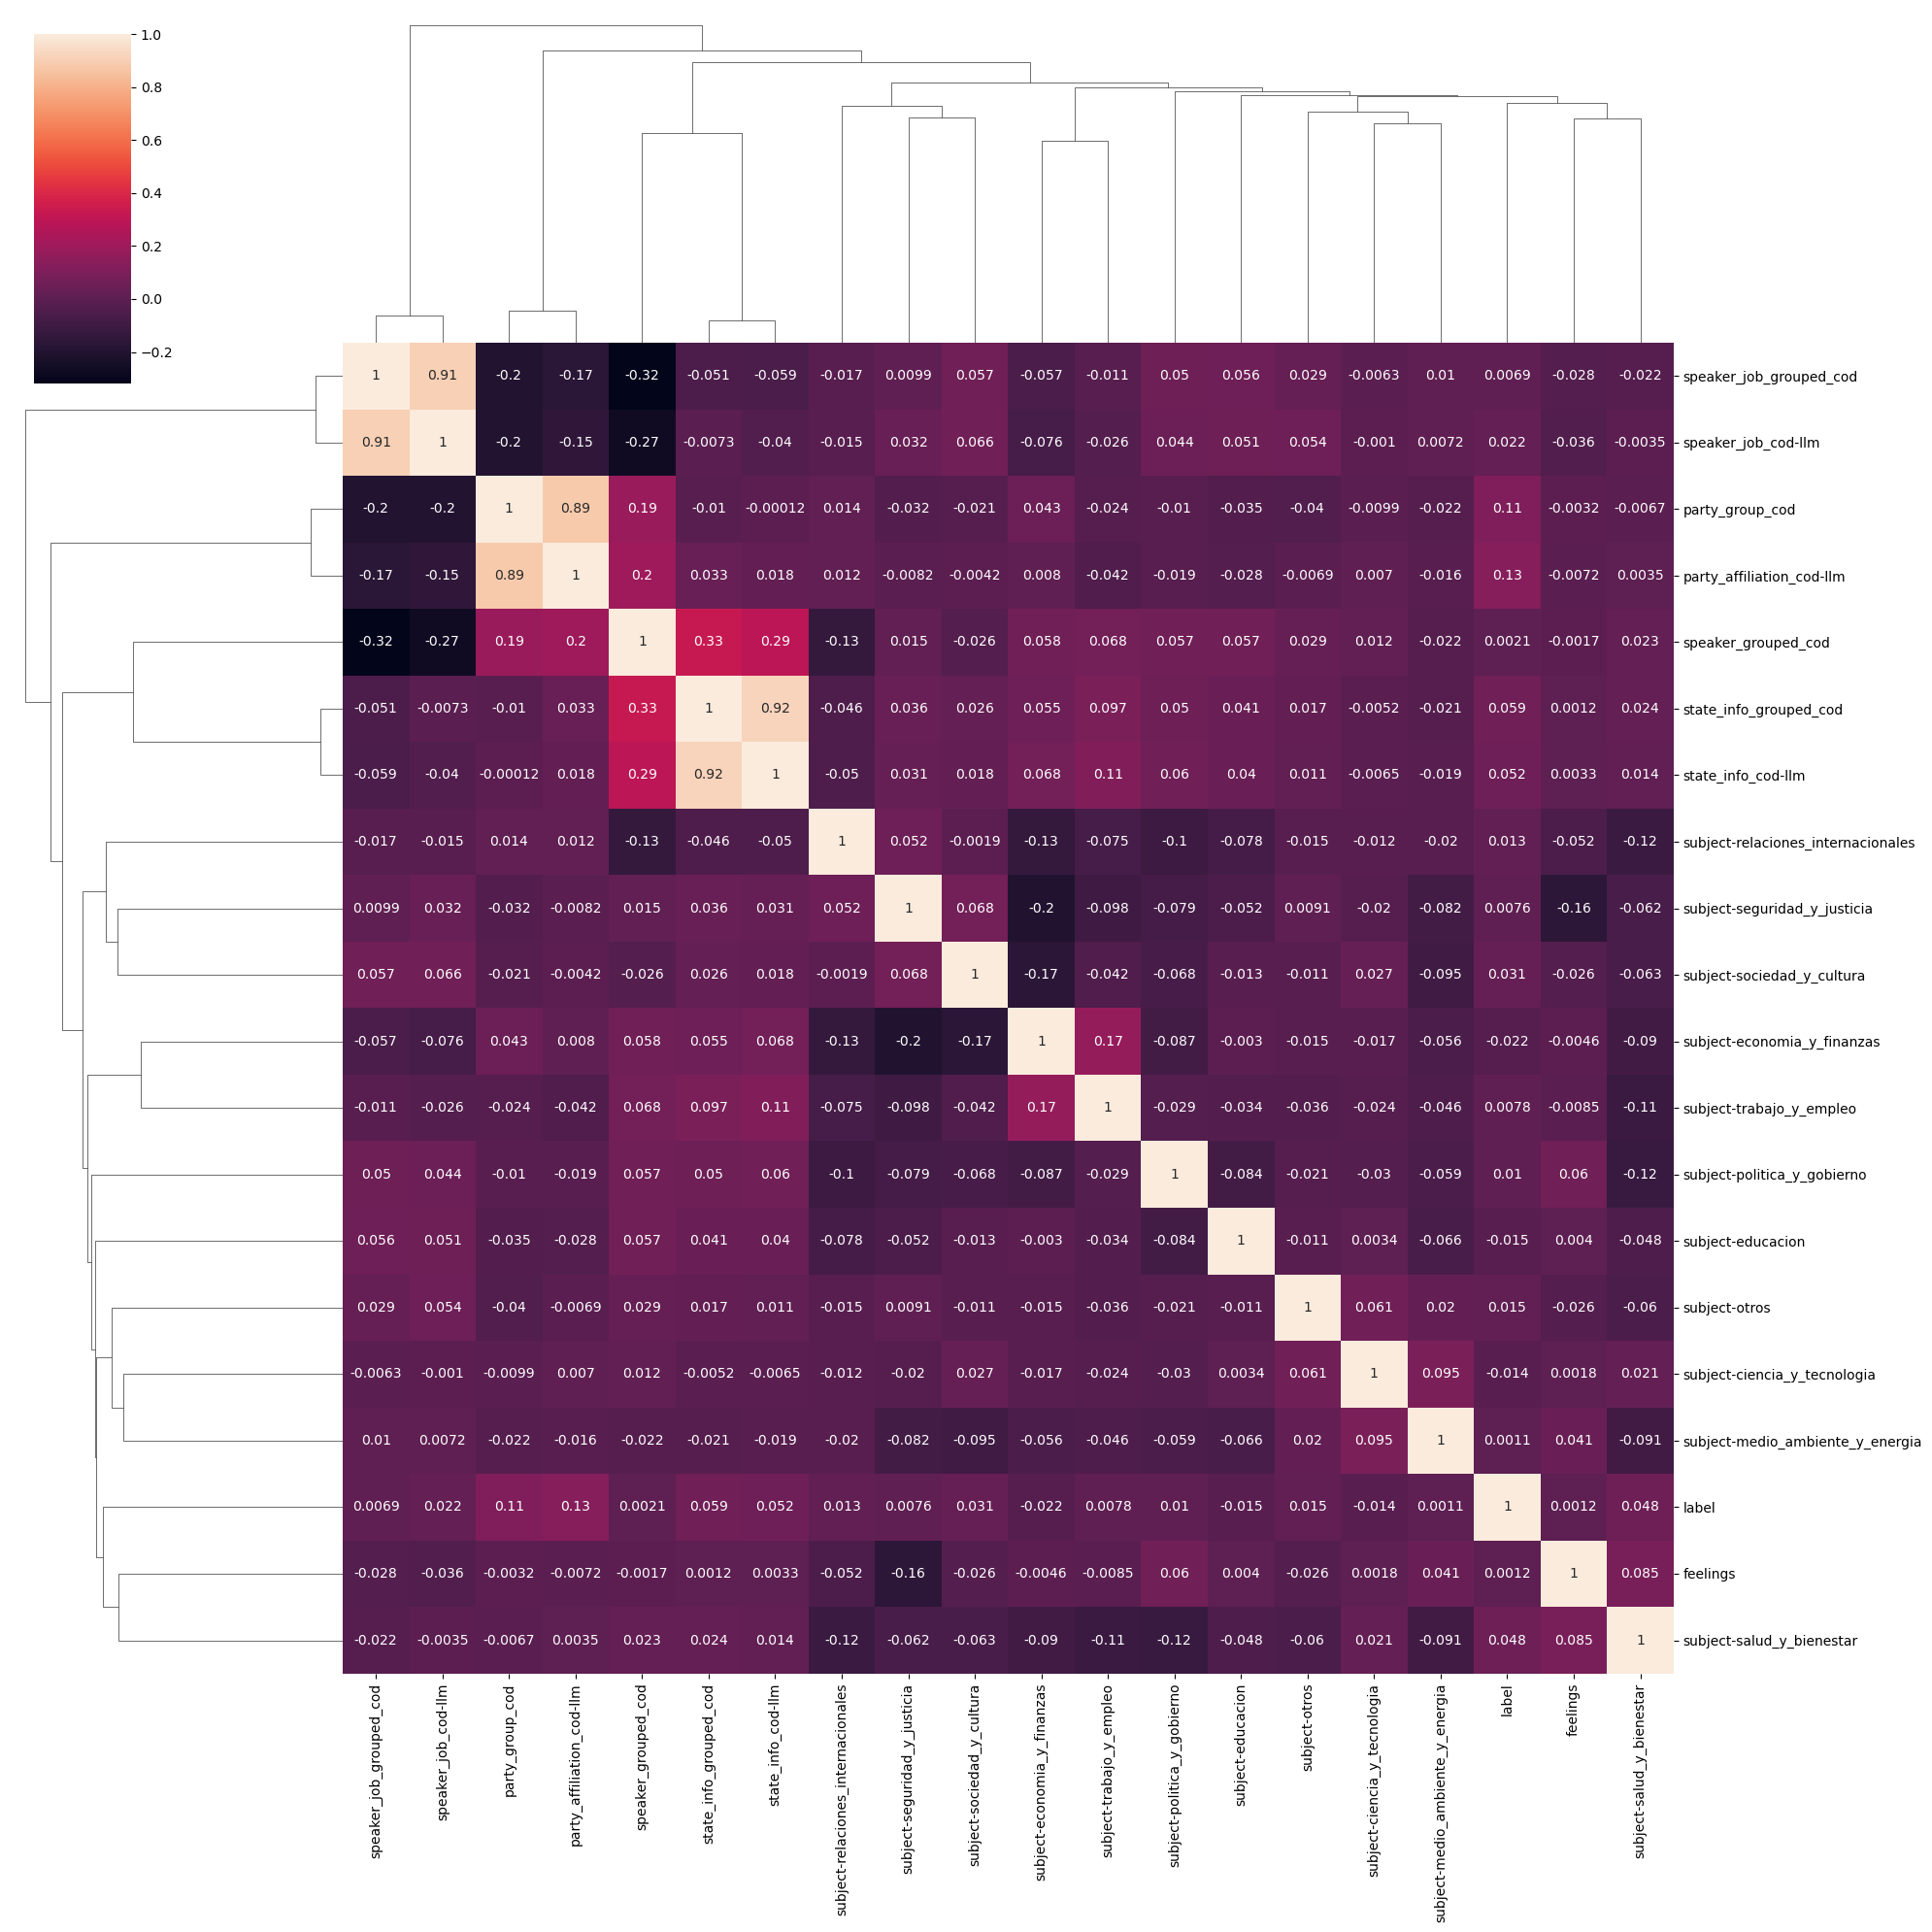

In [101]:
sns.clustermap(corrMatrix, annot=True, figsize=(20,20))
plt.show()

# 8. Referencias

* [pandas documentation — pandas 2.2.3 documentation. (s. f.).](https://pandas.pydata.org/docs/)  
* [“DoC · SPACY API documentation,” Doc.](https://spacy.io/api/doc)